In [1]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
warnings.filterwarnings('ignore', category=UserWarning)

import numpy as np
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
import deepchem as dc

from sklearn.metrics import (
    mutual_info_score, roc_auc_score, average_precision_score,
    precision_score, recall_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from skmultilearn.adapt import MLkNN

from skfp.fingerprints import (
    PubChemFingerprint, LaggnerFingerprint, AvalonFingerprint,
    AtomPairFingerprint, ECFPFingerprint, MACCSFingerprint
)

random_seed = 42
np.random.seed(random_seed)

n_targets  = 100   
n_skip     = 0     
n_features = 15     


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some PyTorch models, missing a dependency. No module named 'transformers'
No module named 'transformers'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'transformers'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped 

In [2]:

smiles_df = pd.read_csv('smiles.csv', header=None)
smiles_list = smiles_df.iloc[:, 0].tolist()


Y_lltpt = pd.read_csv('/home/maciej/studia/praktyki_ibb/lltpt_binary.csv').to_numpy()
Y_hlt = pd.read_csv('/home/maciej/studia/praktyki_ibb/hlt_binary.csv').to_numpy()
Y_hlgt = pd.read_csv('/home/maciej/studia/praktyki_ibb/hlgt_binary.csv').to_numpy()


lltpt_columns = pd.read_csv('/home/maciej/studia/praktyki_ibb/lltpt_binary.csv', nrows=0).columns.astype(str).tolist()
df = pd.DataFrame(Y_lltpt, columns=lltpt_columns)



In [3]:

smiles_list_clean, mols_clean, idx_clean = [], [], []
for i, smi in enumerate(smiles_list):
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        smiles_list_clean.append(smi)
        mols_clean.append(mol)
        idx_clean.append(i)


Y_lltpt_clean = Y_lltpt[idx_clean, :]
Y_hlt_clean = Y_hlt[idx_clean, :]
Y_hlgt_clean = Y_hlgt[idx_clean, :]
df_clean = df.iloc[idx_clean].reset_index(drop=True)



In [4]:

X_dummy = np.zeros((len(smiles_list_clean), 1))
dataset = dc.data.NumpyDataset(X_dummy, y=None, ids=smiles_list_clean)
splitter = dc.splits.ScaffoldSplitter()

train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset,
    frac_train=0.8,
    frac_valid=0.0,
    frac_test=0.2,
    seed=random_seed
)


train_smiles = list(train_dataset.ids)
valid_smiles = list(valid_dataset.ids)
test_smiles = list(test_dataset.ids)


smiles2idx = {smi: i for i, smi in enumerate(smiles_list_clean)}
train_idx = [smiles2idx[smi] for smi in train_smiles]
valid_idx = [smiles2idx[smi] for smi in valid_smiles]
test_idx = [smiles2idx[smi] for smi in test_smiles]




In [5]:

lltpt_ids = pd.read_csv('/home/maciej/studia/praktyki_ibb/lltpt_binary.csv', nrows=0).columns.astype(str).tolist()
lltpt_id_to_col = {col: i for i, col in enumerate(lltpt_ids)}



In [6]:

df_train = df_clean.iloc[train_idx][lltpt_ids].astype(int)

def compute_mi_matrix(df_subset):
    """
    compute full mutual information score matrics

    return
        symetric mutual information score matrix (target x target)
    """
    
    cols = df_subset.columns
    n = len(cols)
    mi_matrix = np.zeros((n, n))
    
    for i in tqdm(range(n), desc='MI -train set'):
        for j in range(i, n):
            mi = mutual_info_score(df_subset[cols[i]], df_subset[cols[j]])
            mi_matrix[i, j] = mi
            mi_matrix[j, i] = mi
    
    return pd.DataFrame(mi_matrix, index=cols, columns=cols)


mi_df_train = compute_mi_matrix(df_train)



MI -train set: 100%|██████████| 1007/1007 [07:24<00:00,  2.27it/s]


In [7]:
mi_stats_train = (
    mi_df_train
    .apply(['mean', 'sum', 'max', 'min'])
    .T
    .reset_index()
    .rename(columns={
        'index': 'lltpt_id',
        'mean': 'mean_mutual_info',
        'sum': 'sum_mutual_info',
        'max': 'max_mutual_info',
        'min': 'min_mutual_info'
    })
)

mi_stats_train_sorted = mi_stats_train.sort_values(
    'mean_mutual_info', ascending=False
)

def uniform_sample_targets(mi_stats_sorted, n_targets):
    """
    uniformly sample n_targets from ranked spectrum of mean MIS
    including lowest and highest targets

    return
        list of selected targets
    """
    total_targets = len(mi_stats_sorted)
    
    if n_targets >= total_targets:
        return mi_stats_sorted['lltpt_id'].tolist()
    
    if n_targets <= 2:
        indices = [0, total_targets - 1] if n_targets == 2 else [0]
        return mi_stats_sorted.iloc[indices]['lltpt_id'].tolist()
    
    step = (total_targets - 1) / (n_targets - 1)
    
    indices = []
    for i in range(n_targets):
        if i == 0:
            indices.append(0)
        elif i == n_targets - 1:
            indices.append(total_targets - 1)
        else:
            indices.append(int(round(i * step)))
    
    indices = sorted(list(set(indices)))
    
    return mi_stats_sorted.iloc[indices]['lltpt_id'].tolist()

chosen_targets = uniform_sample_targets(mi_stats_train_sorted, n_targets)

print(f"{len(chosen_targets)} targets uniformly selected")
print(f"highest MI: {mi_stats_train_sorted.iloc[0]['lltpt_id']} (MI={mi_stats_train_sorted.iloc[0]['mean_mutual_info']:.3f})")
print(f"lowest MI: {mi_stats_train_sorted.iloc[-1]['lltpt_id']} (MI={mi_stats_train_sorted.iloc[-1]['mean_mutual_info']:.3f})")

selected_mi_values = []
for target in chosen_targets:
    mi_val = mi_stats_train_sorted[mi_stats_train_sorted['lltpt_id'] == target]['mean_mutual_info'].iloc[0]
    selected_mi_values.append(mi_val)

print(f"MIS spectrum of selected targets  - min: {min(selected_mi_values):.3f}, max: {max(selected_mi_values):.3f}, mean: {np.mean(selected_mi_values):.3f}")


100 targets uniformly selected
highest MI: 10015090 (MI=0.018)
lowest MI: 10000028 (MI=0.000)
MIS spectrum of selected targets  - min: 0.000, max: 0.018, mean: 0.005


In [8]:

def subset(arr, rows, cols=None):
    res = arr[rows, :]
    return res[:, cols] if cols is not None else res


fingerprints = {
    'PubChem':  PubChemFingerprint(),
    'ECFP4':    ECFPFingerprint(radius=2),
    'MACCS':    MACCSFingerprint(),
    'Laggner':  LaggnerFingerprint(),
    'Avalon':   AvalonFingerprint()
}

models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=100, n_jobs=-1, random_state=random_seed
    ),
    'KNN':          KNeighborsClassifier(n_neighbors=5)
}


results_all           = []
selected_features_all = {}

for t_id in tqdm(chosen_targets, desc='Targets'):

    target_idx = lltpt_id_to_col[t_id]
    row        = mi_df_train.loc[t_id].drop(t_id)
    feature_ids = (
        row.sort_values(ascending=False)
           .iloc[:n_features]
           .index
           .tolist()
    )
    feature_cols = [lltpt_id_to_col[f] for f in feature_ids]

    print(f"selected features: {feature_ids}")

    X_train = subset(Y_lltpt_clean, train_idx, feature_cols)
    X_test  = subset(Y_lltpt_clean, test_idx,  feature_cols)
    y_train = subset(Y_lltpt_clean, train_idx, [target_idx]).ravel()
    y_test  = subset(Y_lltpt_clean, test_idx,  [target_idx]).ravel()


    for fp_name, fp in fingerprints.items():
        X_full = fp.fit_transform(smiles_list_clean)
        if hasattr(X_full, 'toarray'):
            X_full = X_full.toarray()

        X_aug_train = np.hstack([X_full[train_idx], X_train])
        X_aug_test  = np.hstack([X_full[test_idx],  X_test])

        for model_name, model in models.items():
            model.fit(X_aug_train, y_train)
            y_score = model.predict_proba(X_aug_test)[:, 1]
            y_pred  = (y_score >= 0.5).astype(int)

            auc  = roc_auc_score(y_test, y_score)
            aupr = average_precision_score(y_test, y_score)
            prec = precision_score(y_test, y_pred, zero_division=0)
            rec  = recall_score(y_test,  y_pred, zero_division=0)


            print(
                f"{fp_name:7s} + {model_name:12s} "
                f"AUC={auc:.3f}  AUPR={aupr:.3f}  "
                f"P={prec:.3f}  R={rec:.3f}"
            )

            results_all.append({
                'target_id':   t_id,
                'fingerprint': fp_name,
                'model':       model_name,
                'auc':         auc,
                'aupr':        aupr,
                'precision':   prec,
                'recall':      rec
            })

    selected_features_all[t_id] = feature_ids


Targets:   0%|          | 0/100 [00:00<?, ?it/s]

selected features: ['10065716', '10039083', '10003988', '10013968', '10013946', '10040753', '10018867', '10006451', '10028411', '10008479', '10010741', '10011224', '10017853', '10013990', '10035742']
PubChem + RandomForest AUC=0.888  AUPR=0.780  P=0.767  R=0.613
PubChem + KNN          AUC=0.747  AUPR=0.500  P=0.684  R=0.347
ECFP4   + RandomForest AUC=0.879  AUPR=0.776  P=0.742  R=0.613
ECFP4   + KNN          AUC=0.814  AUPR=0.605  P=0.642  R=0.453
MACCS   + RandomForest AUC=0.881  AUPR=0.773  P=0.701  R=0.627
MACCS   + KNN          AUC=0.813  AUPR=0.588  P=0.614  R=0.467
Laggner + RandomForest AUC=0.878  AUPR=0.758  P=0.686  R=0.640
Laggner + KNN          AUC=0.821  AUPR=0.606  P=0.646  R=0.560


Targets:   1%|          | 1/100 [00:37<1:02:17, 37.76s/it]

Avalon  + RandomForest AUC=0.875  AUPR=0.727  P=0.700  R=0.653
Avalon  + KNN          AUC=0.747  AUPR=0.515  P=0.629  R=0.293
selected features: ['10003239', '10040753', '10008479', '10013946', '10028411', '10065716', '10011224', '10039083', '10033371', '10046571', '10003549', '10021789', '10010774', '10015090', '10006451']
PubChem + RandomForest AUC=0.917  AUPR=0.783  P=0.696  R=0.807
PubChem + KNN          AUC=0.775  AUPR=0.581  P=0.573  R=0.534
ECFP4   + RandomForest AUC=0.922  AUPR=0.831  P=0.709  R=0.830
ECFP4   + KNN          AUC=0.843  AUPR=0.689  P=0.728  R=0.670
MACCS   + RandomForest AUC=0.916  AUPR=0.788  P=0.699  R=0.818
MACCS   + KNN          AUC=0.875  AUPR=0.691  P=0.708  R=0.716
Laggner + RandomForest AUC=0.921  AUPR=0.810  P=0.685  R=0.864
Laggner + KNN          AUC=0.895  AUPR=0.749  P=0.747  R=0.841


Targets:   2%|▏         | 2/100 [01:16<1:02:10, 38.06s/it]

Avalon  + RandomForest AUC=0.915  AUPR=0.756  P=0.733  R=0.841
Avalon  + KNN          AUC=0.753  AUPR=0.536  P=0.600  R=0.477
selected features: ['10008479', '10003549', '10011224', '10033775', '10042772', '10015090', '10002855', '10019303', '10041349', '10005734', '10025482', '10035742', '10020772', '10003988', '10028411']
PubChem + RandomForest AUC=0.917  AUPR=0.926  P=0.877  R=0.834
PubChem + KNN          AUC=0.748  AUPR=0.730  P=0.709  R=0.621
ECFP4   + RandomForest AUC=0.927  AUPR=0.929  P=0.884  R=0.890
ECFP4   + KNN          AUC=0.871  AUPR=0.868  P=0.875  R=0.724
MACCS   + RandomForest AUC=0.930  AUPR=0.935  P=0.890  R=0.834
MACCS   + KNN          AUC=0.841  AUPR=0.841  P=0.843  R=0.738
Laggner + RandomForest AUC=0.929  AUPR=0.932  P=0.884  R=0.841
Laggner + KNN          AUC=0.898  AUPR=0.897  P=0.884  R=0.738


Targets:   3%|▎         | 3/100 [01:54<1:01:56, 38.32s/it]

Avalon  + RandomForest AUC=0.921  AUPR=0.925  P=0.871  R=0.834
Avalon  + KNN          AUC=0.777  AUPR=0.764  P=0.768  R=0.662
selected features: ['10033557', '10013990', '10043882', '10044565', '10003068', '10024419', '10029216', '10029446', '10010774', '10047899', '10025482', '10002855', '10027599', '10011781', '10015090']
PubChem + RandomForest AUC=0.913  AUPR=0.812  P=0.857  R=0.500
PubChem + KNN          AUC=0.730  AUPR=0.468  P=0.607  R=0.236
ECFP4   + RandomForest AUC=0.919  AUPR=0.807  P=0.846  R=0.458
ECFP4   + KNN          AUC=0.703  AUPR=0.490  P=1.000  R=0.139
MACCS   + RandomForest AUC=0.926  AUPR=0.824  P=0.824  R=0.583
MACCS   + KNN          AUC=0.851  AUPR=0.656  P=0.794  R=0.375
Laggner + RandomForest AUC=0.919  AUPR=0.810  P=0.745  R=0.569
Laggner + KNN          AUC=0.862  AUPR=0.699  P=0.804  R=0.569


Targets:   4%|▍         | 4/100 [02:32<1:01:06, 38.20s/it]

Avalon  + RandomForest AUC=0.914  AUPR=0.806  P=0.821  R=0.444
Avalon  + KNN          AUC=0.751  AUPR=0.529  P=0.778  R=0.292
selected features: ['10039083', '10040753', '10006451', '10003988', '10028411', '10015090', '10022000', '10013946', '10046571', '10008479', '10003239', '10010741', '10014020', '10033371', '10021789']
PubChem + RandomForest AUC=0.934  AUPR=0.923  P=0.986  R=0.680
PubChem + KNN          AUC=0.768  AUPR=0.639  P=0.795  R=0.350
ECFP4   + RandomForest AUC=0.945  AUPR=0.932  P=0.973  R=0.710
ECFP4   + KNN          AUC=0.897  AUPR=0.825  P=0.903  R=0.560
MACCS   + RandomForest AUC=0.941  AUPR=0.924  P=0.959  R=0.710
MACCS   + KNN          AUC=0.848  AUPR=0.759  P=0.889  R=0.480
Laggner + RandomForest AUC=0.947  AUPR=0.934  P=0.950  R=0.760
Laggner + KNN          AUC=0.883  AUPR=0.854  P=0.958  R=0.690


Targets:   5%|▌         | 5/100 [03:10<1:00:13, 38.03s/it]

Avalon  + RandomForest AUC=0.943  AUPR=0.928  P=0.971  R=0.660
Avalon  + KNN          AUC=0.742  AUPR=0.613  P=0.800  R=0.280
selected features: ['10013573', '10003549', '10000081', '10010774', '10003239', '10012735', '10061284', '10022437', '10002855', '10028411', '10013946', '10003068', '10061273', '10041349', '10003988']
PubChem + RandomForest AUC=0.852  AUPR=0.864  P=0.775  R=0.844
PubChem + KNN          AUC=0.704  AUPR=0.686  P=0.642  R=0.694
ECFP4   + RandomForest AUC=0.855  AUPR=0.858  P=0.770  R=0.864
ECFP4   + KNN          AUC=0.810  AUPR=0.788  P=0.849  R=0.728
MACCS   + RandomForest AUC=0.877  AUPR=0.881  P=0.809  R=0.837
MACCS   + KNN          AUC=0.784  AUPR=0.754  P=0.748  R=0.748
Laggner + RandomForest AUC=0.861  AUPR=0.865  P=0.797  R=0.830
Laggner + KNN          AUC=0.808  AUPR=0.786  P=0.778  R=0.714


Targets:   6%|▌         | 6/100 [03:49<1:00:05, 38.36s/it]

Avalon  + RandomForest AUC=0.850  AUPR=0.855  P=0.775  R=0.844
Avalon  + KNN          AUC=0.720  AUPR=0.711  P=0.688  R=0.660
selected features: ['10047895', '10043554', '10024384', '10042128', '10002034', '10030095', '10061461', '10025482', '10033775', '10028980', '10010774', '10047899', '10028411', '10003549', '10024419']
PubChem + RandomForest AUC=0.897  AUPR=0.807  P=0.828  R=0.516
PubChem + KNN          AUC=0.747  AUPR=0.544  P=0.661  R=0.398
ECFP4   + RandomForest AUC=0.901  AUPR=0.838  P=0.803  R=0.613
ECFP4   + KNN          AUC=0.730  AUPR=0.527  P=0.667  R=0.172
MACCS   + RandomForest AUC=0.906  AUPR=0.836  P=0.787  R=0.634
MACCS   + KNN          AUC=0.841  AUPR=0.688  P=0.800  R=0.516
Laggner + RandomForest AUC=0.911  AUPR=0.832  P=0.827  R=0.667
Laggner + KNN          AUC=0.868  AUPR=0.763  P=0.815  R=0.570


Targets:   7%|▋         | 7/100 [04:28<59:49, 38.60s/it]  

Avalon  + RandomForest AUC=0.902  AUPR=0.829  P=0.842  R=0.516
Avalon  + KNN          AUC=0.706  AUPR=0.524  P=0.639  R=0.419
selected features: ['10047899', '10042772', '10008479', '10033775', '10013968', '10001760', '10003549', '10002855', '10025482', '10015090', '10033371', '10039083', '10028411', '10010774', '10029216']
PubChem + RandomForest AUC=0.842  AUPR=0.838  P=0.798  R=0.664
PubChem + KNN          AUC=0.674  AUPR=0.596  P=0.636  R=0.534
ECFP4   + RandomForest AUC=0.849  AUPR=0.834  P=0.802  R=0.710
ECFP4   + KNN          AUC=0.806  AUPR=0.781  P=0.752  R=0.718
MACCS   + RandomForest AUC=0.852  AUPR=0.839  P=0.824  R=0.679
MACCS   + KNN          AUC=0.755  AUPR=0.701  P=0.740  R=0.542
Laggner + RandomForest AUC=0.843  AUPR=0.834  P=0.793  R=0.702
Laggner + KNN          AUC=0.780  AUPR=0.733  P=0.766  R=0.649


Targets:   8%|▊         | 8/100 [05:06<58:59, 38.47s/it]

Avalon  + RandomForest AUC=0.834  AUPR=0.822  P=0.820  R=0.626
Avalon  + KNN          AUC=0.683  AUPR=0.635  P=0.656  R=0.466
selected features: ['10020852', '10021654', '10027940', '10010741', '10039083', '10025482', '10011781', '10027599', '10003246', '10030216', '10002855', '10065838', '10013946', '10017853', '10001949']
PubChem + RandomForest AUC=0.931  AUPR=0.723  P=0.818  R=0.273
PubChem + KNN          AUC=0.727  AUPR=0.341  P=0.750  R=0.091
ECFP4   + RandomForest AUC=0.923  AUPR=0.669  P=0.812  R=0.394
ECFP4   + KNN          AUC=0.671  AUPR=0.250  P=0.500  R=0.061
MACCS   + RandomForest AUC=0.936  AUPR=0.742  P=0.875  R=0.424
MACCS   + KNN          AUC=0.749  AUPR=0.390  P=0.750  R=0.182
Laggner + RandomForest AUC=0.925  AUPR=0.733  P=0.778  R=0.424
Laggner + KNN          AUC=0.844  AUPR=0.595  P=0.778  R=0.424


Targets:   9%|▉         | 9/100 [05:45<58:30, 38.58s/it]

Avalon  + RandomForest AUC=0.927  AUPR=0.730  P=0.900  R=0.273
Avalon  + KNN          AUC=0.687  AUPR=0.243  P=0.500  R=0.061
selected features: ['10024419', '10018800', '10022437', '10003068', '10010774', '10001760', '10033557', '10021654', '10036018', '10042772', '10043882', '10047899', '10041349', '10029216', '10031127']
PubChem + RandomForest AUC=0.877  AUPR=0.741  P=0.720  R=0.468
PubChem + KNN          AUC=0.740  AUPR=0.542  P=0.675  R=0.351
ECFP4   + RandomForest AUC=0.889  AUPR=0.794  P=0.875  R=0.545
ECFP4   + KNN          AUC=0.783  AUPR=0.569  P=0.714  R=0.325
MACCS   + RandomForest AUC=0.891  AUPR=0.768  P=0.800  R=0.468
MACCS   + KNN          AUC=0.791  AUPR=0.605  P=0.679  R=0.468
Laggner + RandomForest AUC=0.899  AUPR=0.794  P=0.759  R=0.571
Laggner + KNN          AUC=0.869  AUPR=0.727  P=0.730  R=0.597


Targets:  10%|█         | 10/100 [06:24<58:13, 38.81s/it]

Avalon  + RandomForest AUC=0.878  AUPR=0.768  P=0.870  R=0.519
Avalon  + KNN          AUC=0.749  AUPR=0.549  P=0.711  R=0.416
selected features: ['10043458', '10036018', '10016766', '10013990', '10044565', '10003068', '10029446', '10041349', '10017853', '10047340', '10015137', '10043882', '10025197', '10042772', '10001949']
PubChem + RandomForest AUC=0.877  AUPR=0.562  P=0.600  R=0.209
PubChem + KNN          AUC=0.705  AUPR=0.326  P=0.714  R=0.116
ECFP4   + RandomForest AUC=0.885  AUPR=0.608  P=0.682  R=0.349
ECFP4   + KNN          AUC=0.801  AUPR=0.434  P=0.636  R=0.326
MACCS   + RandomForest AUC=0.882  AUPR=0.560  P=0.684  R=0.302
MACCS   + KNN          AUC=0.757  AUPR=0.433  P=0.733  R=0.256
Laggner + RandomForest AUC=0.884  AUPR=0.622  P=0.714  R=0.349
Laggner + KNN          AUC=0.801  AUPR=0.518  P=0.760  R=0.442


Targets:  11%|█         | 11/100 [07:03<57:28, 38.75s/it]

Avalon  + RandomForest AUC=0.875  AUPR=0.559  P=0.688  R=0.256
Avalon  + KNN          AUC=0.681  AUPR=0.317  P=0.600  R=0.140
selected features: ['10017944', '10029202', '10061284', '10046566', '10061273', '10061087', '10021425', '10061280', '10061024', '10059245', '10054716', '10061021', '10002034', '10000081', '10019717']
PubChem + RandomForest AUC=0.936  AUPR=0.818  P=0.839  R=0.681
PubChem + KNN          AUC=0.782  AUPR=0.513  P=0.675  R=0.391
ECFP4   + RandomForest AUC=0.944  AUPR=0.877  P=0.935  R=0.623
ECFP4   + KNN          AUC=0.756  AUPR=0.522  P=0.857  R=0.087
MACCS   + RandomForest AUC=0.941  AUPR=0.869  P=0.833  R=0.725
MACCS   + KNN          AUC=0.862  AUPR=0.706  P=0.791  R=0.493
Laggner + RandomForest AUC=0.949  AUPR=0.876  P=0.817  R=0.710
Laggner + KNN          AUC=0.908  AUPR=0.762  P=0.830  R=0.638


Targets:  12%|█▏        | 12/100 [07:42<56:55, 38.81s/it]

Avalon  + RandomForest AUC=0.941  AUPR=0.845  P=0.882  R=0.652
Avalon  + KNN          AUC=0.803  AUPR=0.513  P=0.667  R=0.261
selected features: ['10042128', '10013786', '10013911', '10015090', '10018867', '10003239', '10009887', '10002034', '10072575', '10016029', '10013950', '10008531', '10025197', '10038063', '10017888']
PubChem + RandomForest AUC=0.882  AUPR=0.545  P=0.750  R=0.200
PubChem + KNN          AUC=0.667  AUPR=0.201  P=0.667  R=0.067
ECFP4   + RandomForest AUC=0.905  AUPR=0.582  P=0.778  R=0.233
ECFP4   + KNN          AUC=0.647  AUPR=0.237  P=0.500  R=0.033
MACCS   + RandomForest AUC=0.888  AUPR=0.577  P=0.700  R=0.233
MACCS   + KNN          AUC=0.722  AUPR=0.276  P=0.714  R=0.167
Laggner + RandomForest AUC=0.880  AUPR=0.611  P=0.706  R=0.400
Laggner + KNN          AUC=0.788  AUPR=0.450  P=0.667  R=0.400


Targets:  13%|█▎        | 13/100 [08:21<56:13, 38.78s/it]

Avalon  + RandomForest AUC=0.885  AUPR=0.493  P=0.500  R=0.067
Avalon  + KNN          AUC=0.611  AUPR=0.171  P=0.667  R=0.067
selected features: ['10010305', '10037211', '10002855', '10041349', '10003591', '10061920', '10044565', '10012239', '10015535', '10013395', '10029412', '10043882', '10003068', '10029216', '10010947']
PubChem + RandomForest AUC=0.882  AUPR=0.796  P=0.864  R=0.586
PubChem + KNN          AUC=0.734  AUPR=0.529  P=0.571  R=0.460
ECFP4   + RandomForest AUC=0.891  AUPR=0.825  P=0.850  R=0.586
ECFP4   + KNN          AUC=0.803  AUPR=0.695  P=0.808  R=0.483
MACCS   + RandomForest AUC=0.900  AUPR=0.819  P=0.857  R=0.621
MACCS   + KNN          AUC=0.804  AUPR=0.651  P=0.729  R=0.494
Laggner + RandomForest AUC=0.895  AUPR=0.824  P=0.869  R=0.609
Laggner + KNN          AUC=0.808  AUPR=0.708  P=0.800  R=0.552


Targets:  14%|█▍        | 14/100 [08:59<55:28, 38.71s/it]

Avalon  + RandomForest AUC=0.882  AUPR=0.799  P=0.900  R=0.517
Avalon  + KNN          AUC=0.712  AUPR=0.489  P=0.507  R=0.402
selected features: ['10013908', '10006298', '10027599', '10036018', '10046916', '10011781', '10046910', '10006451', '10013935', '10001928', '10027940', '10015090', '10021654', '10038063', '10025197']
PubChem + RandomForest AUC=0.913  AUPR=0.605  P=1.000  R=0.211
PubChem + KNN          AUC=0.530  AUPR=0.074  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.890  AUPR=0.687  P=1.000  R=0.368
ECFP4   + KNN          AUC=0.628  AUPR=0.145  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.894  AUPR=0.628  P=0.700  R=0.368
MACCS   + KNN          AUC=0.736  AUPR=0.239  P=0.600  R=0.158
Laggner + RandomForest AUC=0.916  AUPR=0.684  P=0.900  R=0.474
Laggner + KNN          AUC=0.836  AUPR=0.528  P=0.667  R=0.421


Targets:  15%|█▌        | 15/100 [09:38<54:49, 38.70s/it]

Avalon  + RandomForest AUC=0.898  AUPR=0.615  P=1.000  R=0.158
Avalon  + KNN          AUC=0.604  AUPR=0.141  P=1.000  R=0.053
selected features: ['10010947', '10017577', '10046543', '10046555', '10012218', '10013887', '10042264', '10013916', '10003591', '10037211', '10020910', '10020400', '10006811', '10011953', '10013950']
PubChem + RandomForest AUC=0.890  AUPR=0.584  P=0.800  R=0.222
PubChem + KNN          AUC=0.649  AUPR=0.112  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.859  AUPR=0.587  P=0.833  R=0.278
ECFP4   + KNN          AUC=0.526  AUPR=0.119  P=1.000  R=0.056
MACCS   + RandomForest AUC=0.902  AUPR=0.609  P=0.900  R=0.500
MACCS   + KNN          AUC=0.705  AUPR=0.278  P=1.000  R=0.111
Laggner + RandomForest AUC=0.873  AUPR=0.658  P=0.818  R=0.500
Laggner + KNN          AUC=0.810  AUPR=0.507  P=0.800  R=0.444


Targets:  16%|█▌        | 16/100 [10:17<54:25, 38.87s/it]

Avalon  + RandomForest AUC=0.837  AUPR=0.572  P=1.000  R=0.167
Avalon  + KNN          AUC=0.625  AUPR=0.111  P=0.000  R=0.000
selected features: ['10043431', '10020852', '10024642', '10029216', '10001949', '10003591', '10013950', '10013036', '10043882', '10015090', '10041466', '10043458', '10019063', '10042264', '10041349']
PubChem + RandomForest AUC=0.890  AUPR=0.590  P=0.714  R=0.161
PubChem + KNN          AUC=0.634  AUPR=0.194  P=0.333  R=0.032
ECFP4   + RandomForest AUC=0.894  AUPR=0.594  P=0.714  R=0.161
ECFP4   + KNN          AUC=0.741  AUPR=0.323  P=0.667  R=0.129
MACCS   + RandomForest AUC=0.907  AUPR=0.624  P=0.692  R=0.290
MACCS   + KNN          AUC=0.739  AUPR=0.345  P=0.667  R=0.194
Laggner + RandomForest AUC=0.898  AUPR=0.639  P=0.714  R=0.323
Laggner + KNN          AUC=0.809  AUPR=0.479  P=0.667  R=0.387


Targets:  17%|█▋        | 17/100 [10:56<53:58, 39.02s/it]

Avalon  + RandomForest AUC=0.894  AUPR=0.589  P=0.500  R=0.065
Avalon  + KNN          AUC=0.685  AUPR=0.206  P=0.000  R=0.000
selected features: ['10008629', '10003246', '10020852', '10019974', '10020603', '10011781', '10029223', '10003285', '10011953', '10017888', '10030216', '10043261', '10014184', '10008612', '10028622']
PubChem + RandomForest AUC=0.937  AUPR=0.594  P=1.000  R=0.143
PubChem + KNN          AUC=0.530  AUPR=0.100  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.881  AUPR=0.561  P=1.000  R=0.143
ECFP4   + KNN          AUC=0.627  AUPR=0.230  P=1.000  R=0.048
MACCS   + RandomForest AUC=0.912  AUPR=0.570  P=0.833  R=0.238
MACCS   + KNN          AUC=0.718  AUPR=0.357  P=1.000  R=0.095
Laggner + RandomForest AUC=0.907  AUPR=0.545  P=0.857  R=0.286
Laggner + KNN          AUC=0.749  AUPR=0.407  P=0.750  R=0.286


Targets:  18%|█▊        | 18/100 [11:35<53:13, 38.95s/it]

Avalon  + RandomForest AUC=0.912  AUPR=0.521  P=0.800  R=0.190
Avalon  + KNN          AUC=0.575  AUPR=0.192  P=1.000  R=0.048
selected features: ['10027141', '10038063', '10018867', '10015090', '10015137', '10017955', '10017853', '10002034', '10030216', '10014080', '10035742', '10009887', '10018964', '10029223', '10042128']
PubChem + RandomForest AUC=0.913  AUPR=0.438  P=0.571  R=0.222
PubChem + KNN          AUC=0.669  AUPR=0.160  P=0.200  R=0.056
ECFP4   + RandomForest AUC=0.905  AUPR=0.468  P=0.400  R=0.111
ECFP4   + KNN          AUC=0.622  AUPR=0.129  P=0.500  R=0.056
MACCS   + RandomForest AUC=0.929  AUPR=0.554  P=0.750  R=0.333
MACCS   + KNN          AUC=0.802  AUPR=0.313  P=0.600  R=0.167
Laggner + RandomForest AUC=0.919  AUPR=0.518  P=0.600  R=0.333
Laggner + KNN          AUC=0.864  AUPR=0.364  P=0.421  R=0.444


Targets:  19%|█▉        | 19/100 [12:15<52:57, 39.23s/it]

Avalon  + RandomForest AUC=0.923  AUPR=0.442  P=0.500  R=0.056
Avalon  + KNN          AUC=0.680  AUPR=0.176  P=0.000  R=0.000
selected features: ['10027313', '10046910', '10046916', '10013935', '10015090', '10027599', '10013990', '10006298', '10037377', '10011781', '10013786', '10014020', '10006237', '10006451', '10038063']
PubChem + RandomForest AUC=0.952  AUPR=0.690  P=0.857  R=0.316
PubChem + KNN          AUC=0.711  AUPR=0.213  P=0.667  R=0.105
ECFP4   + RandomForest AUC=0.944  AUPR=0.712  P=0.833  R=0.263
ECFP4   + KNN          AUC=0.788  AUPR=0.369  P=0.600  R=0.158
MACCS   + RandomForest AUC=0.945  AUPR=0.763  P=1.000  R=0.421
MACCS   + KNN          AUC=0.783  AUPR=0.413  P=1.000  R=0.158
Laggner + RandomForest AUC=0.947  AUPR=0.764  P=0.889  R=0.421
Laggner + KNN          AUC=0.874  AUPR=0.582  P=0.875  R=0.368


Targets:  20%|██        | 20/100 [12:54<52:07, 39.09s/it]

Avalon  + RandomForest AUC=0.944  AUPR=0.794  P=1.000  R=0.211
Avalon  + KNN          AUC=0.756  AUPR=0.294  P=1.000  R=0.105
selected features: ['10017577', '10010947', '10013950', '10013036', '10029864', '10042264', '10027940', '10043431', '10072575', '10011953', '10035742', '10001949', '10003591', '10020745', '10013887']
PubChem + RandomForest AUC=0.946  AUPR=0.336  P=0.000  R=0.000
PubChem + KNN          AUC=0.520  AUPR=0.023  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.903  AUPR=0.319  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.472  AUPR=0.022  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.923  AUPR=0.257  P=0.000  R=0.000
MACCS   + KNN          AUC=0.778  AUPR=0.091  P=0.000  R=0.000
Laggner + RandomForest AUC=0.910  AUPR=0.272  P=0.000  R=0.000
Laggner + KNN          AUC=0.813  AUPR=0.272  P=0.500  R=0.167


Targets:  21%|██        | 21/100 [13:33<51:31, 39.14s/it]

Avalon  + RandomForest AUC=0.937  AUPR=0.330  P=0.500  R=0.167
Avalon  + KNN          AUC=0.412  AUPR=0.022  P=0.000  R=0.000
selected features: ['10001949', '10046543', '10013036', '10043431', '10010947', '10027940', '10042264', '10061920', '10011953', '10028622', '10012357', '10042464', '10021654', '10037211', '10020910']
PubChem + RandomForest AUC=0.861  AUPR=0.586  P=1.000  R=0.130
PubChem + KNN          AUC=0.691  AUPR=0.277  P=1.000  R=0.043
ECFP4   + RandomForest AUC=0.912  AUPR=0.655  P=1.000  R=0.174
ECFP4   + KNN          AUC=0.665  AUPR=0.296  P=1.000  R=0.043
MACCS   + RandomForest AUC=0.914  AUPR=0.622  P=0.750  R=0.261
MACCS   + KNN          AUC=0.807  AUPR=0.490  P=0.500  R=0.043
Laggner + RandomForest AUC=0.900  AUPR=0.583  P=0.778  R=0.304
Laggner + KNN          AUC=0.783  AUPR=0.453  P=0.800  R=0.348


Targets:  22%|██▏       | 22/100 [14:13<51:18, 39.46s/it]

Avalon  + RandomForest AUC=0.926  AUPR=0.639  P=1.000  R=0.174
Avalon  + KNN          AUC=0.738  AUPR=0.325  P=0.000  R=0.000
selected features: ['10021114', '10040867', '10017888', '10015137', '10003285', '10046916', '10013786', '10027313', '10027599', '10008629', '10021654', '10072575', '10029223', '10065838', '10043949']
PubChem + RandomForest AUC=0.847  AUPR=0.591  P=0.000  R=0.000
PubChem + KNN          AUC=0.659  AUPR=0.116  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.873  AUPR=0.638  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.800  AUPR=0.293  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.900  AUPR=0.501  P=1.000  R=0.182
MACCS   + KNN          AUC=0.717  AUPR=0.278  P=0.000  R=0.000
Laggner + RandomForest AUC=0.903  AUPR=0.680  P=1.000  R=0.364
Laggner + KNN          AUC=0.810  AUPR=0.441  P=0.800  R=0.364


Targets:  23%|██▎       | 23/100 [14:54<50:55, 39.68s/it]

Avalon  + RandomForest AUC=0.870  AUPR=0.628  P=0.000  R=0.000
Avalon  + KNN          AUC=0.700  AUPR=0.143  P=0.000  R=0.000
selected features: ['10019303', '10013968', '10005734', '10008479', '10033557', '10042772', '10006482', '10019301', '10003119', '10043882', '10044565', '10060800', '10011224', '10033775', '10013911']
PubChem + RandomForest AUC=0.811  AUPR=0.712  P=0.754  R=0.438
PubChem + KNN          AUC=0.654  AUPR=0.530  P=0.609  R=0.400
ECFP4   + RandomForest AUC=0.817  AUPR=0.764  P=0.800  R=0.495
ECFP4   + KNN          AUC=0.766  AUPR=0.644  P=0.740  R=0.543
MACCS   + RandomForest AUC=0.817  AUPR=0.730  P=0.759  R=0.571
MACCS   + KNN          AUC=0.701  AUPR=0.569  P=0.613  R=0.438
Laggner + RandomForest AUC=0.819  AUPR=0.728  P=0.746  R=0.505
Laggner + KNN          AUC=0.764  AUPR=0.628  P=0.727  R=0.533


Targets:  24%|██▍       | 24/100 [15:34<50:26, 39.82s/it]

Avalon  + RandomForest AUC=0.822  AUPR=0.723  P=0.803  R=0.467
Avalon  + KNN          AUC=0.623  AUPR=0.493  P=0.597  R=0.352
selected features: ['10061428', '10013946', '10061273', '10017885', '10000081', '10061284', '10000087', '10029202', '10061087', '10017944', '10016256', '10033645', '10021789', '10016766', '10025482']
PubChem + RandomForest AUC=0.831  AUPR=0.468  P=0.667  R=0.125
PubChem + KNN          AUC=0.642  AUPR=0.173  P=0.300  R=0.094
ECFP4   + RandomForest AUC=0.830  AUPR=0.487  P=0.667  R=0.062
ECFP4   + KNN          AUC=0.716  AUPR=0.234  P=0.500  R=0.062
MACCS   + RandomForest AUC=0.821  AUPR=0.523  P=0.636  R=0.219
MACCS   + KNN          AUC=0.708  AUPR=0.249  P=0.400  R=0.188
Laggner + RandomForest AUC=0.834  AUPR=0.518  P=0.625  R=0.156
Laggner + KNN          AUC=0.731  AUPR=0.305  P=0.538  R=0.219


Targets:  25%|██▌       | 25/100 [16:14<49:57, 39.97s/it]

Avalon  + RandomForest AUC=0.810  AUPR=0.415  P=0.333  R=0.031
Avalon  + KNN          AUC=0.561  AUPR=0.146  P=0.250  R=0.062
selected features: ['10030216', '10003285', '10015137', '10029223', '10006811', '10019974', '10020852', '10009887', '10003246', '10017888', '10014184', '10046916', '10016029', '10065838', '10027599']
PubChem + RandomForest AUC=0.916  AUPR=0.325  P=0.500  R=0.067
PubChem + KNN          AUC=0.592  AUPR=0.082  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.889  AUPR=0.409  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.551  AUPR=0.113  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.937  AUPR=0.355  P=0.333  R=0.067
MACCS   + KNN          AUC=0.650  AUPR=0.200  P=0.000  R=0.000
Laggner + RandomForest AUC=0.924  AUPR=0.415  P=0.500  R=0.133
Laggner + KNN          AUC=0.800  AUPR=0.261  P=0.286  R=0.133


Targets:  26%|██▌       | 26/100 [16:55<49:29, 40.13s/it]

Avalon  + RandomForest AUC=0.913  AUPR=0.422  P=0.000  R=0.000
Avalon  + KNN          AUC=0.604  AUPR=0.102  P=0.000  R=0.000
selected features: ['10042128', '10015137', '10018498', '10018386', '10072575', '10009887', '10030216', '10039083', '10027599', '10027313', '10010741', '10017888', '10020852', '10013990', '10011878']
PubChem + RandomForest AUC=0.850  AUPR=0.234  P=0.000  R=0.000
PubChem + KNN          AUC=0.644  AUPR=0.135  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.806  AUPR=0.227  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.566  AUPR=0.092  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.853  AUPR=0.209  P=0.000  R=0.000
MACCS   + KNN          AUC=0.608  AUPR=0.101  P=0.000  R=0.000
Laggner + RandomForest AUC=0.861  AUPR=0.277  P=0.333  R=0.083
Laggner + KNN          AUC=0.681  AUPR=0.149  P=0.250  R=0.083


Targets:  27%|██▋       | 27/100 [17:34<48:42, 40.04s/it]

Avalon  + RandomForest AUC=0.810  AUPR=0.235  P=0.000  R=0.000
Avalon  + KNN          AUC=0.630  AUPR=0.087  P=0.000  R=0.000
selected features: ['10061529', '10028980', '10061273', '10054716', '10061280', '10021789', '10062000', '10017944', '10046566', '10001760', '10061284', '10059245', '10002034', '10061021', '10061024']
PubChem + RandomForest AUC=0.961  AUPR=0.839  P=1.000  R=0.588
PubChem + KNN          AUC=0.755  AUPR=0.220  P=0.500  R=0.059
ECFP4   + RandomForest AUC=0.923  AUPR=0.820  P=1.000  R=0.529
ECFP4   + KNN          AUC=0.768  AUPR=0.387  P=1.000  R=0.059
MACCS   + RandomForest AUC=0.968  AUPR=0.844  P=1.000  R=0.706
MACCS   + KNN          AUC=0.911  AUPR=0.538  P=0.714  R=0.294
Laggner + RandomForest AUC=0.967  AUPR=0.866  P=1.000  R=0.706
Laggner + KNN          AUC=0.893  AUPR=0.708  P=0.833  R=0.588


Targets:  28%|██▊       | 28/100 [18:14<47:51, 39.88s/it]

Avalon  + RandomForest AUC=0.968  AUPR=0.854  P=1.000  R=0.353
Avalon  + KNN          AUC=0.682  AUPR=0.123  P=0.000  R=0.000
selected features: ['10019303', '10005734', '10037211', '10042772', '10013968', '10044565', '10019301', '10043882', '10010741', '10014020', '10025197', '10016825', '10011703', '10010071', '10002855']
PubChem + RandomForest AUC=0.898  AUPR=0.601  P=0.800  R=0.133
PubChem + KNN          AUC=0.668  AUPR=0.173  P=0.143  R=0.033
ECFP4   + RandomForest AUC=0.910  AUPR=0.581  P=1.000  R=0.067
ECFP4   + KNN          AUC=0.808  AUPR=0.346  P=0.448  R=0.433
MACCS   + RandomForest AUC=0.907  AUPR=0.556  P=0.600  R=0.100
MACCS   + KNN          AUC=0.714  AUPR=0.250  P=0.500  R=0.100
Laggner + RandomForest AUC=0.905  AUPR=0.602  P=0.769  R=0.333
Laggner + KNN          AUC=0.865  AUPR=0.466  P=0.556  R=0.333


Targets:  29%|██▉       | 29/100 [18:55<47:49, 40.41s/it]

Avalon  + RandomForest AUC=0.883  AUPR=0.458  P=0.500  R=0.033
Avalon  + KNN          AUC=0.698  AUPR=0.282  P=0.625  R=0.167
selected features: ['10019301', '10005734', '10037423', '10003119', '10038669', '10002974', '10006482', '10034567', '10019303', '10063119', '10047290', '10023891', '10013968', '10024855', '10020772']
PubChem + RandomForest AUC=0.869  AUPR=0.589  P=0.588  R=0.196
PubChem + KNN          AUC=0.674  AUPR=0.354  P=0.526  R=0.196
ECFP4   + RandomForest AUC=0.886  AUPR=0.663  P=0.800  R=0.235
ECFP4   + KNN          AUC=0.761  AUPR=0.401  P=0.556  R=0.196
MACCS   + RandomForest AUC=0.873  AUPR=0.688  P=0.840  R=0.412
MACCS   + KNN          AUC=0.765  AUPR=0.440  P=0.650  R=0.255
Laggner + RandomForest AUC=0.875  AUPR=0.690  P=0.750  R=0.353
Laggner + KNN          AUC=0.812  AUPR=0.527  P=0.750  R=0.294


Targets:  30%|███       | 30/100 [19:34<46:31, 39.87s/it]

Avalon  + RandomForest AUC=0.866  AUPR=0.612  P=0.909  R=0.196
Avalon  + KNN          AUC=0.665  AUPR=0.295  P=0.379  R=0.216
selected features: ['10042602', '10019301', '10003658', '10028836', '10047290', '10033557', '10065341', '10019303', '10014020', '10014363', '10024378', '10043882', '10027599', '10044565', '10037211']
PubChem + RandomForest AUC=0.840  AUPR=0.355  P=0.000  R=0.000
PubChem + KNN          AUC=0.581  AUPR=0.136  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.837  AUPR=0.467  P=0.500  R=0.067
ECFP4   + KNN          AUC=0.728  AUPR=0.334  P=0.667  R=0.133
MACCS   + RandomForest AUC=0.870  AUPR=0.435  P=0.500  R=0.100
MACCS   + KNN          AUC=0.676  AUPR=0.188  P=0.250  R=0.033
Laggner + RandomForest AUC=0.879  AUPR=0.451  P=0.571  R=0.133
Laggner + KNN          AUC=0.746  AUPR=0.322  P=0.556  R=0.167


Targets:  31%|███       | 31/100 [20:12<45:06, 39.23s/it]

Avalon  + RandomForest AUC=0.835  AUPR=0.486  P=0.667  R=0.067
Avalon  + KNN          AUC=0.647  AUPR=0.178  P=0.333  R=0.033
selected features: ['10003239', '10061087', '10046306', '10003988', '10011224', '10028411', '10028334', '10061280', '10016256', '10029202', '10008479', '10033371', '10017944', '10061284', '10046571']
PubChem + RandomForest AUC=0.838  AUPR=0.423  P=0.667  R=0.091
PubChem + KNN          AUC=0.581  AUPR=0.114  P=0.500  R=0.045
ECFP4   + RandomForest AUC=0.840  AUPR=0.344  P=0.667  R=0.091
ECFP4   + KNN          AUC=0.612  AUPR=0.131  P=0.500  R=0.045
MACCS   + RandomForest AUC=0.849  AUPR=0.358  P=0.500  R=0.091
MACCS   + KNN          AUC=0.776  AUPR=0.198  P=0.300  R=0.136
Laggner + RandomForest AUC=0.878  AUPR=0.387  P=0.429  R=0.136
Laggner + KNN          AUC=0.808  AUPR=0.247  P=0.385  R=0.227


Targets:  32%|███▏      | 32/100 [20:49<43:51, 38.70s/it]

Avalon  + RandomForest AUC=0.859  AUPR=0.343  P=0.000  R=0.000
Avalon  + KNN          AUC=0.568  AUPR=0.119  P=0.500  R=0.045
selected features: ['10018687', '10014950', '10018916', '10043554', '10024384', '10042033', '10015218', '10018386', '10044223', '10043882', '10065553', '10023126', '10025197', '10037660', '10002967']
PubChem + RandomForest AUC=0.810  AUPR=0.469  P=0.625  R=0.098
PubChem + KNN          AUC=0.619  AUPR=0.249  P=0.263  R=0.098
ECFP4   + RandomForest AUC=0.845  AUPR=0.572  P=0.727  R=0.157
ECFP4   + KNN          AUC=0.621  AUPR=0.264  P=0.300  R=0.059
MACCS   + RandomForest AUC=0.852  AUPR=0.580  P=0.722  R=0.255
MACCS   + KNN          AUC=0.717  AUPR=0.357  P=0.588  R=0.196
Laggner + RandomForest AUC=0.855  AUPR=0.586  P=0.667  R=0.235
Laggner + KNN          AUC=0.731  AUPR=0.437  P=0.615  R=0.314


Targets:  33%|███▎      | 33/100 [21:27<42:57, 38.47s/it]

Avalon  + RandomForest AUC=0.803  AUPR=0.491  P=0.556  R=0.098
Avalon  + KNN          AUC=0.618  AUPR=0.259  P=0.364  R=0.157
selected features: ['10039020', '10019717', '10019842', '10028372', '10028411', '10025197', '10001949', '10002027', '10015137', '10037868', '10033645', '10034960', '10018276', '10047895', '10007636']
PubChem + RandomForest AUC=0.869  AUPR=0.340  P=0.500  R=0.048
PubChem + KNN          AUC=0.623  AUPR=0.181  P=0.250  R=0.048
ECFP4   + RandomForest AUC=0.861  AUPR=0.434  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.672  AUPR=0.201  P=0.500  R=0.048
MACCS   + RandomForest AUC=0.905  AUPR=0.406  P=0.500  R=0.048
MACCS   + KNN          AUC=0.672  AUPR=0.177  P=0.333  R=0.048
Laggner + RandomForest AUC=0.900  AUPR=0.415  P=0.333  R=0.048
Laggner + KNN          AUC=0.747  AUPR=0.308  P=0.667  R=0.286


Targets:  34%|███▍      | 34/100 [22:06<42:18, 38.46s/it]

Avalon  + RandomForest AUC=0.910  AUPR=0.435  P=0.000  R=0.000
Avalon  + KNN          AUC=0.633  AUPR=0.140  P=0.500  R=0.048
selected features: ['10012218', '10014020', '10031127', '10013990', '10021654', '10043458', '10043882', '10013911', '10001949', '10020852', '10015958', '10016766', '10017853', '10061284', '10013786']
PubChem + RandomForest AUC=0.920  AUPR=0.298  P=0.500  R=0.100
PubChem + KNN          AUC=0.649  AUPR=0.110  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.796  AUPR=0.189  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.727  AUPR=0.179  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.921  AUPR=0.337  P=1.000  R=0.100
MACCS   + KNN          AUC=0.712  AUPR=0.175  P=0.500  R=0.100
Laggner + RandomForest AUC=0.935  AUPR=0.427  P=1.000  R=0.100
Laggner + KNN          AUC=0.760  AUPR=0.371  P=0.600  R=0.300


Targets:  35%|███▌      | 35/100 [22:43<41:21, 38.17s/it]

Avalon  + RandomForest AUC=0.955  AUPR=0.435  P=0.000  R=0.000
Avalon  + KNN          AUC=0.651  AUPR=0.178  P=1.000  R=0.100
selected features: ['10065735', '10012357', '10043431', '10027327', '10015137', '10013786', '10011953', '10027599', '10020852', '10029333', '10009887', '10043458', '10024642', '10039424', '10013911']
PubChem + RandomForest AUC=0.870  AUPR=0.360  P=0.333  R=0.100
PubChem + KNN          AUC=0.647  AUPR=0.082  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.874  AUPR=0.339  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.693  AUPR=0.222  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.893  AUPR=0.287  P=0.333  R=0.100
MACCS   + KNN          AUC=0.782  AUPR=0.298  P=0.667  R=0.200
Laggner + RandomForest AUC=0.910  AUPR=0.332  P=0.400  R=0.200
Laggner + KNN          AUC=0.729  AUPR=0.254  P=0.375  R=0.300


Targets:  36%|███▌      | 36/100 [23:22<40:47, 38.24s/it]

Avalon  + RandomForest AUC=0.878  AUPR=0.348  P=0.000  R=0.000
Avalon  + KNN          AUC=0.657  AUPR=0.113  P=0.000  R=0.000
selected features: ['10020578', '10035598', '10021037', '10042128', '10035742', '10013950', '10007882', '10028694', '10021027', '10013786', '10015090', '10047895', '10040047', '10037377', '10016288']
PubChem + RandomForest AUC=0.929  AUPR=0.320  P=1.000  R=0.100
PubChem + KNN          AUC=0.569  AUPR=0.089  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.895  AUPR=0.352  P=1.000  R=0.100
ECFP4   + KNN          AUC=0.631  AUPR=0.094  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.930  AUPR=0.479  P=1.000  R=0.100
MACCS   + KNN          AUC=0.576  AUPR=0.229  P=1.000  R=0.200
Laggner + RandomForest AUC=0.969  AUPR=0.514  P=0.500  R=0.100
Laggner + KNN          AUC=0.782  AUPR=0.308  P=0.667  R=0.200


Targets:  37%|███▋      | 37/100 [24:00<40:14, 38.32s/it]

Avalon  + RandomForest AUC=0.940  AUPR=0.315  P=1.000  R=0.100
Avalon  + KNN          AUC=0.661  AUPR=0.088  P=0.000  R=0.000
selected features: ['10035598', '10035742', '10034484', '10017955', '10040047', '10015090', '10028116', '10007554', '10028154', '10002034', '10028694', '10016288', '10003658', '10042128', '10008531']
PubChem + RandomForest AUC=0.987  AUPR=0.621  P=1.000  R=0.125
PubChem + KNN          AUC=0.795  AUPR=0.330  P=1.000  R=0.125
ECFP4   + RandomForest AUC=0.944  AUPR=0.437  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.790  AUPR=0.267  P=1.000  R=0.125
MACCS   + RandomForest AUC=0.952  AUPR=0.366  P=0.333  R=0.125
MACCS   + KNN          AUC=0.794  AUPR=0.336  P=0.667  R=0.250
Laggner + RandomForest AUC=0.969  AUPR=0.460  P=0.500  R=0.125
Laggner + KNN          AUC=0.850  AUPR=0.267  P=0.500  R=0.125


Targets:  38%|███▊      | 38/100 [24:38<39:22, 38.11s/it]

Avalon  + RandomForest AUC=0.959  AUPR=0.396  P=0.000  R=0.000
Avalon  + KNN          AUC=0.603  AUPR=0.057  P=0.000  R=0.000
selected features: ['10023230', '10005470', '10028334', '10059245', '10046566', '10061021', '10061087', '10028810', '10047895', '10000087', '10029410', '10029202', '10061284', '10006100', '10028372']
PubChem + RandomForest AUC=0.926  AUPR=0.244  P=0.000  R=0.000
PubChem + KNN          AUC=0.640  AUPR=0.056  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.838  AUPR=0.255  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.496  AUPR=0.022  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.972  AUPR=0.342  P=0.000  R=0.000
MACCS   + KNN          AUC=0.568  AUPR=0.185  P=0.000  R=0.000
Laggner + RandomForest AUC=0.924  AUPR=0.468  P=0.000  R=0.000
Laggner + KNN          AUC=0.820  AUPR=0.349  P=0.000  R=0.000


Targets:  39%|███▉      | 39/100 [25:16<38:43, 38.09s/it]

Avalon  + RandomForest AUC=0.943  AUPR=0.540  P=0.000  R=0.000
Avalon  + KNN          AUC=0.717  AUPR=0.082  P=0.000  R=0.000
selected features: ['10023126', '10019717', '10019663', '10015218', '10042033', '10062000', '10044223', '10000081', '10046735', '10002034', '10046916', '10043554', '10015867', '10024690', '10056375']
PubChem + RandomForest AUC=0.787  AUPR=0.488  P=0.833  R=0.213
PubChem + KNN          AUC=0.608  AUPR=0.258  P=0.556  R=0.106
ECFP4   + RandomForest AUC=0.758  AUPR=0.440  P=0.833  R=0.106
ECFP4   + KNN          AUC=0.655  AUPR=0.304  P=0.538  R=0.149
MACCS   + RandomForest AUC=0.830  AUPR=0.514  P=0.800  R=0.170
MACCS   + KNN          AUC=0.660  AUPR=0.320  P=0.562  R=0.191
Laggner + RandomForest AUC=0.815  AUPR=0.522  P=0.818  R=0.191
Laggner + KNN          AUC=0.708  AUPR=0.343  P=0.500  R=0.234


Targets:  40%|████      | 40/100 [25:54<38:11, 38.18s/it]

Avalon  + RandomForest AUC=0.798  AUPR=0.465  P=0.889  R=0.170
Avalon  + KNN          AUC=0.610  AUPR=0.273  P=0.533  R=0.170
selected features: ['10031282', '10040753', '10003285', '10013946', '10046571', '10018498', '10006451', '10028411', '10012601', '10065716', '10021654', '10017888', '10047899', '10007739', '10029223']
PubChem + RandomForest AUC=0.863  AUPR=0.346  P=1.000  R=0.062
PubChem + KNN          AUC=0.636  AUPR=0.105  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.863  AUPR=0.241  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.714  AUPR=0.198  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.844  AUPR=0.263  P=0.000  R=0.000
MACCS   + KNN          AUC=0.726  AUPR=0.174  P=0.000  R=0.000
Laggner + RandomForest AUC=0.834  AUPR=0.248  P=0.000  R=0.000
Laggner + KNN          AUC=0.734  AUPR=0.201  P=0.444  R=0.250


Targets:  41%|████      | 41/100 [26:32<37:20, 37.98s/it]

Avalon  + RandomForest AUC=0.847  AUPR=0.330  P=0.000  R=0.000
Avalon  + KNN          AUC=0.598  AUPR=0.078  P=0.000  R=0.000
selected features: ['10035528', '10018884', '10001551', '10005364', '10003481', '10041349', '10061428', '10022437', '10029354', '10015090', '10013946', '10010774', '10061273', '10011224', '10018838']
PubChem + RandomForest AUC=0.838  AUPR=0.159  P=0.000  R=0.000
PubChem + KNN          AUC=0.523  AUPR=0.042  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.786  AUPR=0.190  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.567  AUPR=0.035  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.752  AUPR=0.244  P=1.000  R=0.167
MACCS   + KNN          AUC=0.523  AUPR=0.023  P=0.000  R=0.000
Laggner + RandomForest AUC=0.721  AUPR=0.192  P=0.500  R=0.167
Laggner + KNN          AUC=0.545  AUPR=0.185  P=1.000  R=0.167


Targets:  42%|████▏     | 42/100 [27:09<36:35, 37.86s/it]

Avalon  + RandomForest AUC=0.854  AUPR=0.180  P=0.000  R=0.000
Avalon  + KNN          AUC=0.616  AUPR=0.052  P=0.000  R=0.000
selected features: ['10022086', '10042674', '10022067', '10002198', '10021425', '10033371', '10059245', '10015150', '10034567', '10005734', '10029202', '10022085', '10022078', '10003988', '10020751']
PubChem + RandomForest AUC=0.793  AUPR=0.449  P=1.000  R=0.152
PubChem + KNN          AUC=0.673  AUPR=0.289  P=0.714  R=0.152
ECFP4   + RandomForest AUC=0.784  AUPR=0.470  P=0.857  R=0.182
ECFP4   + KNN          AUC=0.770  AUPR=0.328  P=0.412  R=0.212
MACCS   + RandomForest AUC=0.834  AUPR=0.485  P=0.857  R=0.182
MACCS   + KNN          AUC=0.631  AUPR=0.266  P=0.600  R=0.182
Laggner + RandomForest AUC=0.837  AUPR=0.434  P=0.625  R=0.152
Laggner + KNN          AUC=0.682  AUPR=0.264  P=0.571  R=0.121


Targets:  43%|████▎     | 43/100 [27:48<36:09, 38.07s/it]

Avalon  + RandomForest AUC=0.834  AUPR=0.461  P=0.833  R=0.152
Avalon  + KNN          AUC=0.677  AUPR=0.257  P=0.385  R=0.152
selected features: ['10017853', '10061021', '10046566', '10013911', '10054716', '10021114', '10027599', '10017888', '10039674', '10024642', '10013786', '10062000', '10027141', '10016100', '10046571']
PubChem + RandomForest AUC=0.863  AUPR=0.364  P=0.000  R=0.000
PubChem + KNN          AUC=0.699  AUPR=0.131  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.877  AUPR=0.213  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.560  AUPR=0.042  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.934  AUPR=0.478  P=0.000  R=0.000
MACCS   + KNN          AUC=0.843  AUPR=0.388  P=1.000  R=0.143
Laggner + RandomForest AUC=0.865  AUPR=0.442  P=0.000  R=0.000
Laggner + KNN          AUC=0.767  AUPR=0.380  P=0.500  R=0.286


Targets:  44%|████▍     | 44/100 [28:32<37:17, 39.95s/it]

Avalon  + RandomForest AUC=0.845  AUPR=0.532  P=0.000  R=0.000
Avalon  + KNN          AUC=0.621  AUPR=0.059  P=0.000  R=0.000
selected features: ['10046910', '10006298', '10037377', '10013935', '10027313', '10043570', '10013908', '10046543', '10027599', '10001760', '10046916', '10008190', '10040829', '10028980', '10034263']
PubChem + RandomForest AUC=0.867  AUPR=0.153  P=0.000  R=0.000
PubChem + KNN          AUC=0.534  AUPR=0.033  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.850  AUPR=0.194  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.553  AUPR=0.046  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.909  AUPR=0.269  P=0.000  R=0.000
MACCS   + KNN          AUC=0.795  AUPR=0.240  P=0.000  R=0.000
Laggner + RandomForest AUC=0.864  AUPR=0.253  P=0.000  R=0.000
Laggner + KNN          AUC=0.792  AUPR=0.240  P=0.400  R=0.250


Targets:  45%|████▌     | 45/100 [29:13<36:46, 40.11s/it]

Avalon  + RandomForest AUC=0.909  AUPR=0.243  P=0.000  R=0.000
Avalon  + KNN          AUC=0.591  AUPR=0.047  P=0.000  R=0.000
selected features: ['10047284', '10034567', '10002198', '10003553', '10006482', '10005734', '10013968', '10046735', '10023845', '10019303', '10042772', '10002424', '10020751', '10019301', '10043570']
PubChem + RandomForest AUC=0.718  AUPR=0.358  P=0.545  R=0.120
PubChem + KNN          AUC=0.572  AUPR=0.276  P=0.524  R=0.220
ECFP4   + RandomForest AUC=0.756  AUPR=0.454  P=0.800  R=0.160
ECFP4   + KNN          AUC=0.645  AUPR=0.281  P=0.455  R=0.200
MACCS   + RandomForest AUC=0.766  AUPR=0.471  P=0.636  R=0.140
MACCS   + KNN          AUC=0.716  AUPR=0.336  P=0.500  R=0.240
Laggner + RandomForest AUC=0.727  AUPR=0.412  P=0.600  R=0.180
Laggner + KNN          AUC=0.661  AUPR=0.322  P=0.560  R=0.280


Targets:  46%|████▌     | 46/100 [29:55<36:45, 40.84s/it]

Avalon  + RandomForest AUC=0.733  AUPR=0.445  P=0.875  R=0.140
Avalon  + KNN          AUC=0.637  AUPR=0.270  P=0.450  R=0.180
selected features: ['10029354', '10002034', '10016288', '10021058', '10034620', '10035742', '10028116', '10003481', '10020947', '10040047', '10001551', '10020578', '10021789', '10012174', '10021017']
PubChem + RandomForest AUC=0.920  AUPR=0.422  P=1.000  R=0.071
PubChem + KNN          AUC=0.632  AUPR=0.238  P=1.000  R=0.143
ECFP4   + RandomForest AUC=0.904  AUPR=0.538  P=1.000  R=0.143
ECFP4   + KNN          AUC=0.836  AUPR=0.292  P=1.000  R=0.071
MACCS   + RandomForest AUC=0.941  AUPR=0.477  P=1.000  R=0.143
MACCS   + KNN          AUC=0.642  AUPR=0.169  P=0.667  R=0.143
Laggner + RandomForest AUC=0.939  AUPR=0.546  P=1.000  R=0.143
Laggner + KNN          AUC=0.779  AUPR=0.245  P=0.667  R=0.143


Targets:  47%|████▋     | 47/100 [30:35<35:55, 40.67s/it]

Avalon  + RandomForest AUC=0.951  AUPR=0.518  P=0.000  R=0.000
Avalon  + KNN          AUC=0.590  AUPR=0.080  P=0.000  R=0.000
selected features: ['10002383', '10012601', '10028596', '10065735', '10036956', '10035742', '10065838', '10007554', '10061024', '10006451', '10017888', '10029223', '10014184', '10020772', '10008190']
PubChem + RandomForest AUC=0.858  AUPR=0.365  P=0.000  R=0.000
PubChem + KNN          AUC=0.574  AUPR=0.046  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.850  AUPR=0.360  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.578  AUPR=0.092  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.908  AUPR=0.426  P=1.000  R=0.100
MACCS   + KNN          AUC=0.611  AUPR=0.074  P=0.000  R=0.000
Laggner + RandomForest AUC=0.881  AUPR=0.365  P=1.000  R=0.100
Laggner + KNN          AUC=0.760  AUPR=0.199  P=0.500  R=0.200


Targets:  48%|████▊     | 48/100 [31:17<35:23, 40.84s/it]

Avalon  + RandomForest AUC=0.857  AUPR=0.381  P=0.000  R=0.000
Avalon  + KNN          AUC=0.527  AUPR=0.039  P=0.000  R=0.000
selected features: ['10018867', '10065837', '10043949', '10043261', '10027566', '10011781', '10009887', '10028034', '10029223', '10027141', '10006811', '10001906', '10038063', '10036018', '10018498']
PubChem + RandomForest AUC=0.946  AUPR=0.318  P=0.000  R=0.000
PubChem + KNN          AUC=0.485  AUPR=0.018  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.834  AUPR=0.267  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.493  AUPR=0.018  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.955  AUPR=0.487  P=0.000  R=0.000
MACCS   + KNN          AUC=0.593  AUPR=0.054  P=0.000  R=0.000
Laggner + RandomForest AUC=0.918  AUPR=0.319  P=0.000  R=0.000
Laggner + KNN          AUC=0.690  AUPR=0.255  P=0.000  R=0.000


Targets:  49%|████▉     | 49/100 [31:58<34:57, 41.13s/it]

Avalon  + RandomForest AUC=0.953  AUPR=0.245  P=0.000  R=0.000
Avalon  + KNN          AUC=0.580  AUPR=0.031  P=0.000  R=0.000
selected features: ['10040867', '10025197', '10047555', '10013950', '10037868', '10029446', '10015958', '10007882', '10034636', '10065837', '10007559', '10007636', '10047895', '10072575', '10003591']
PubChem + RandomForest AUC=0.950  AUPR=0.300  P=0.000  R=0.000
PubChem + KNN          AUC=0.656  AUPR=0.055  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.954  AUPR=0.521  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.491  AUPR=0.011  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.955  AUPR=0.490  P=0.000  R=0.000
MACCS   + KNN          AUC=0.489  AUPR=0.011  P=0.000  R=0.000
Laggner + RandomForest AUC=0.963  AUPR=0.692  P=0.000  R=0.000
Laggner + KNN          AUC=0.819  AUPR=0.226  P=0.500  R=0.333


Targets:  50%|█████     | 50/100 [32:41<34:30, 41.42s/it]

Avalon  + RandomForest AUC=0.953  AUPR=0.242  P=0.000  R=0.000
Avalon  + KNN          AUC=0.476  AUPR=0.011  P=0.000  R=0.000
selected features: ['10019063', '10033664', '10001949', '10061920', '10013496', '10037211', '10027175', '10024264', '10015535', '10010305', '10047340', '10043882', '10042464', '10012239', '10002855']
PubChem + RandomForest AUC=0.873  AUPR=0.260  P=0.000  R=0.000
PubChem + KNN          AUC=0.607  AUPR=0.109  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.833  AUPR=0.333  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.714  AUPR=0.232  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.865  AUPR=0.375  P=0.000  R=0.000
MACCS   + KNN          AUC=0.741  AUPR=0.238  P=0.000  R=0.000
Laggner + RandomForest AUC=0.899  AUPR=0.358  P=0.000  R=0.000
Laggner + KNN          AUC=0.743  AUPR=0.230  P=0.000  R=0.000


Targets:  51%|█████     | 51/100 [33:25<34:30, 42.25s/it]

Avalon  + RandomForest AUC=0.876  AUPR=0.277  P=0.000  R=0.000
Avalon  + KNN          AUC=0.656  AUPR=0.128  P=0.000  R=0.000
selected features: ['10046916', '10006298', '10061021', '10027599', '10013935', '10000084', '10046910', '10046996', '10008570', '10046571', '10036018', '10046901', '10019022', '10065838', '10016766']
PubChem + RandomForest AUC=0.874  AUPR=0.101  P=0.000  R=0.000
PubChem + KNN          AUC=0.675  AUPR=0.064  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.781  AUPR=0.076  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.672  AUPR=0.058  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.905  AUPR=0.115  P=0.000  R=0.000
MACCS   + KNN          AUC=0.668  AUPR=0.055  P=0.000  R=0.000
Laggner + RandomForest AUC=0.835  AUPR=0.291  P=0.000  R=0.000
Laggner + KNN          AUC=0.772  AUPR=0.113  P=0.000  R=0.000


Targets:  52%|█████▏    | 52/100 [34:07<33:47, 42.23s/it]

Avalon  + RandomForest AUC=0.911  AUPR=0.124  P=0.000  R=0.000
Avalon  + KNN          AUC=0.658  AUPR=0.044  P=0.000  R=0.000
selected features: ['10024264', '10013496', '10013887', '10033664', '10013916', '10003591', '10010144', '10052904', '10065604', '10041349', '10016338', '10002368', '10016256', '10037213', '10040984']
PubChem + RandomForest AUC=0.918  AUPR=0.331  P=1.000  R=0.200
PubChem + KNN          AUC=0.561  AUPR=0.023  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.672  AUPR=0.391  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.480  AUPR=0.018  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.895  AUPR=0.524  P=1.000  R=0.200
MACCS   + KNN          AUC=0.568  AUPR=0.025  P=0.000  R=0.000
Laggner + RandomForest AUC=0.929  AUPR=0.488  P=1.000  R=0.200
Laggner + KNN          AUC=0.686  AUPR=0.311  P=1.000  R=0.200


Targets:  53%|█████▎    | 53/100 [34:50<33:20, 42.57s/it]

Avalon  + RandomForest AUC=0.937  AUPR=0.397  P=0.000  R=0.000
Avalon  + KNN          AUC=0.554  AUPR=0.022  P=0.000  R=0.000
selected features: ['10033371', '10016059', '10003988', '10022687', '10018286', '10012174', '10013950', '10043458', '10072575', '10020937', '10000087', '10014020', '10028347', '10036018', '10016825']
PubChem + RandomForest AUC=0.929  AUPR=0.373  P=0.000  R=0.000
PubChem + KNN          AUC=0.719  AUPR=0.114  P=0.333  R=0.167
ECFP4   + RandomForest AUC=0.870  AUPR=0.214  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.739  AUPR=0.386  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.950  AUPR=0.244  P=0.000  R=0.000
MACCS   + KNN          AUC=0.867  AUPR=0.138  P=0.000  R=0.000
Laggner + RandomForest AUC=0.952  AUPR=0.218  P=0.000  R=0.000
Laggner + KNN          AUC=0.873  AUPR=0.202  P=0.500  R=0.167


Targets:  54%|█████▍    | 54/100 [35:30<31:56, 41.65s/it]

Avalon  + RandomForest AUC=0.907  AUPR=0.163  P=0.000  R=0.000
Avalon  + KNN          AUC=0.713  AUPR=0.161  P=0.400  R=0.333
selected features: ['10016288', '10028116', '10040047', '10035742', '10045170', '10035598', '10002034', '10029354', '10008531', '10038435', '10061024', '10059245', '10003481', '10046566', '10007882']
PubChem + RandomForest AUC=0.914  AUPR=0.448  P=1.000  R=0.250
PubChem + KNN          AUC=0.600  AUPR=0.136  P=0.500  R=0.250
ECFP4   + RandomForest AUC=0.933  AUPR=0.354  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.615  AUPR=0.052  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.961  AUPR=0.431  P=0.000  R=0.000
MACCS   + KNN          AUC=0.727  AUPR=0.285  P=1.000  R=0.250
Laggner + RandomForest AUC=0.950  AUPR=0.387  P=1.000  R=0.250
Laggner + KNN          AUC=0.600  AUPR=0.052  P=0.000  R=0.000


Targets:  55%|█████▌    | 55/100 [36:09<30:37, 40.84s/it]

Avalon  + RandomForest AUC=0.967  AUPR=0.592  P=0.000  R=0.000
Avalon  + KNN          AUC=0.580  AUPR=0.021  P=0.000  R=0.000
selected features: ['10027627', '10040868', '10040799', '10020864', '10040925', '10043189', '10015150', '10013786', '10040907', '10039218', '10003055', '10001382', '10000496', '10003053', '10018478']
PubChem + RandomForest AUC=0.864  AUPR=0.423  P=0.500  R=0.053
PubChem + KNN          AUC=0.573  AUPR=0.139  P=1.000  R=0.053
ECFP4   + RandomForest AUC=0.882  AUPR=0.447  P=1.000  R=0.053
ECFP4   + KNN          AUC=0.604  AUPR=0.176  P=1.000  R=0.053
MACCS   + RandomForest AUC=0.862  AUPR=0.405  P=1.000  R=0.105
MACCS   + KNN          AUC=0.680  AUPR=0.275  P=1.000  R=0.053
Laggner + RandomForest AUC=0.885  AUPR=0.463  P=1.000  R=0.105
Laggner + KNN          AUC=0.643  AUPR=0.268  P=1.000  R=0.105


Targets:  56%|█████▌    | 56/100 [36:48<29:35, 40.35s/it]

Avalon  + RandomForest AUC=0.810  AUPR=0.350  P=1.000  R=0.053
Avalon  + KNN          AUC=0.580  AUPR=0.179  P=1.000  R=0.105
selected features: ['10023126', '10018916', '10015218', '10018687', '10014950', '10024384', '10002967', '10019717', '10044223', '10012456', '10033645', '10046735', '10042033', '10002424', '10018800']
PubChem + RandomForest AUC=0.883  AUPR=0.492  P=1.000  R=0.062
PubChem + KNN          AUC=0.692  AUPR=0.210  P=0.375  R=0.094
ECFP4   + RandomForest AUC=0.888  AUPR=0.567  P=0.857  R=0.188
ECFP4   + KNN          AUC=0.822  AUPR=0.441  P=0.667  R=0.250
MACCS   + RandomForest AUC=0.900  AUPR=0.545  P=0.778  R=0.219
MACCS   + KNN          AUC=0.782  AUPR=0.399  P=0.643  R=0.281
Laggner + RandomForest AUC=0.897  AUPR=0.531  P=0.667  R=0.188
Laggner + KNN          AUC=0.824  AUPR=0.402  P=0.474  R=0.281


Targets:  57%|█████▋    | 57/100 [37:28<28:56, 40.39s/it]

Avalon  + RandomForest AUC=0.890  AUPR=0.558  P=0.600  R=0.094
Avalon  + KNN          AUC=0.722  AUPR=0.345  P=0.625  R=0.312
selected features: ['10023126', '10065553', '10028034', '10024384', '10013950', '10037868', '10013916', '10020745', '10018800', '10009887', '10030963', '10007882', '10006811', '10028622', '10028347']
PubChem + RandomForest AUC=0.780  AUPR=0.306  P=0.000  R=0.000
PubChem + KNN          AUC=0.655  AUPR=0.136  P=0.333  R=0.050
ECFP4   + RandomForest AUC=0.726  AUPR=0.191  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.603  AUPR=0.138  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.804  AUPR=0.296  P=0.000  R=0.000
MACCS   + KNN          AUC=0.623  AUPR=0.145  P=0.500  R=0.100
Laggner + RandomForest AUC=0.775  AUPR=0.409  P=1.000  R=0.050
Laggner + KNN          AUC=0.627  AUPR=0.194  P=0.667  R=0.100


Targets:  58%|█████▊    | 58/100 [38:12<29:00, 41.44s/it]

Avalon  + RandomForest AUC=0.740  AUPR=0.306  P=0.000  R=0.000
Avalon  + KNN          AUC=0.582  AUPR=0.118  P=0.400  R=0.100
selected features: ['10040753', '10000087', '10028810', '10022000', '10044055', '10006451', '10047461', '10017888', '10014020', '10040872', '10040742', '10028735', '10021789', '10039101', '10010741']
PubChem + RandomForest AUC=0.923  AUPR=0.566  P=0.000  R=0.000
PubChem + KNN          AUC=0.668  AUPR=0.105  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.828  AUPR=0.185  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.483  AUPR=0.029  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.948  AUPR=0.358  P=0.000  R=0.000
MACCS   + KNN          AUC=0.668  AUPR=0.113  P=0.000  R=0.000
Laggner + RandomForest AUC=0.888  AUPR=0.609  P=0.000  R=0.000
Laggner + KNN          AUC=0.795  AUPR=0.328  P=0.000  R=0.000


Targets:  59%|█████▉    | 59/100 [38:55<28:36, 41.86s/it]

Avalon  + RandomForest AUC=0.933  AUPR=0.415  P=0.000  R=0.000
Avalon  + KNN          AUC=0.656  AUPR=0.077  P=0.000  R=0.000
selected features: ['10040799', '10040868', '10027627', '10043189', '10020864', '10016936', '10003694', '10007764', '10021664', '10001382', '10041541', '10021519', '10011652', '10001684', '10029425']
PubChem + RandomForest AUC=0.684  AUPR=0.504  P=1.000  R=0.500
PubChem + KNN          AUC=0.747  AUPR=0.504  P=1.000  R=0.500
ECFP4   + RandomForest AUC=0.666  AUPR=0.504  P=1.000  R=0.500
ECFP4   + KNN          AUC=0.750  AUPR=0.504  P=1.000  R=0.500
MACCS   + RandomForest AUC=0.698  AUPR=0.504  P=1.000  R=0.500
MACCS   + KNN          AUC=0.747  AUPR=0.504  P=1.000  R=0.500
Laggner + RandomForest AUC=0.709  AUPR=0.504  P=1.000  R=0.500
Laggner + KNN          AUC=0.750  AUPR=0.504  P=1.000  R=0.500


Targets:  60%|██████    | 60/100 [39:35<27:27, 41.20s/it]

Avalon  + RandomForest AUC=0.633  AUPR=0.504  P=1.000  R=0.500
Avalon  + KNN          AUC=0.744  AUPR=0.504  P=0.200  R=0.500
selected features: ['10015867', '10019468', '10035742', '10017955', '10002948', '10008190', '10043607', '10041466', '10013950', '10043554', '10024378', '10003068', '10021017', '10003662', '10036051']
PubChem + RandomForest AUC=0.808  AUPR=0.141  P=0.000  R=0.000
PubChem + KNN          AUC=0.514  AUPR=0.034  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.781  AUPR=0.152  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.675  AUPR=0.081  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.865  AUPR=0.184  P=0.000  R=0.000
MACCS   + KNN          AUC=0.688  AUPR=0.103  P=0.000  R=0.000
Laggner + RandomForest AUC=0.905  AUPR=0.178  P=0.000  R=0.000
Laggner + KNN          AUC=0.622  AUPR=0.062  P=0.000  R=0.000


Targets:  61%|██████    | 61/100 [40:15<26:40, 41.04s/it]

Avalon  + RandomForest AUC=0.892  AUPR=0.163  P=0.000  R=0.000
Avalon  + KNN          AUC=0.470  AUPR=0.032  P=0.000  R=0.000
selected features: ['10018388', '10031009', '10072575', '10043991', '10040742', '10044055', '10033433', '10018276', '10002034', '10033371', '10040882', '10000087', '10019022', '10036018', '10013950']
PubChem + RandomForest AUC=0.966  AUPR=0.359  P=0.000  R=0.000
PubChem + KNN          AUC=0.476  AUPR=0.014  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.964  AUPR=0.624  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.487  AUPR=0.014  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.994  AUPR=0.761  P=0.000  R=0.000
MACCS   + KNN          AUC=0.484  AUPR=0.014  P=0.000  R=0.000
Laggner + RandomForest AUC=0.988  AUPR=0.600  P=0.000  R=0.000
Laggner + KNN          AUC=0.610  AUPR=0.039  P=0.000  R=0.000


Targets:  62%|██████▏   | 62/100 [41:00<26:37, 42.03s/it]

Avalon  + RandomForest AUC=0.951  AUPR=0.289  P=0.000  R=0.000
Avalon  + KNN          AUC=0.474  AUPR=0.014  P=0.000  R=0.000
selected features: ['10002948', '10013887', '10044565', '10011878', '10020937', '10003239', '10010741', '10029331', '10000081', '10010947', '10014020', '10008479', '10033425', '10033371', '10027374']
PubChem + RandomForest AUC=0.936  AUPR=0.495  P=0.000  R=0.000
PubChem + KNN          AUC=0.597  AUPR=0.160  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.916  AUPR=0.352  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.608  AUPR=0.067  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.922  AUPR=0.221  P=0.000  R=0.000
MACCS   + KNN          AUC=0.666  AUPR=0.127  P=0.000  R=0.000
Laggner + RandomForest AUC=0.932  AUPR=0.492  P=0.000  R=0.000
Laggner + KNN          AUC=0.781  AUPR=0.241  P=0.000  R=0.000


Targets:  63%|██████▎   | 63/100 [41:42<25:53, 41.98s/it]

Avalon  + RandomForest AUC=0.885  AUPR=0.270  P=0.000  R=0.000
Avalon  + KNN          AUC=0.590  AUPR=0.045  P=0.000  R=0.000
selected features: ['10037884', '10059245', '10021425', '10037867', '10061280', '10017944', '10029202', '10037855', '10046566', '10000087', '10061087', '10061273', '10062000', '10028810', '10064579']
PubChem + RandomForest AUC=0.527  AUPR=0.185  P=0.000  R=0.000
PubChem + KNN          AUC=0.509  AUPR=0.150  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.555  AUPR=0.153  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.550  AUPR=0.041  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.566  AUPR=0.164  P=0.000  R=0.000
MACCS   + KNN          AUC=0.533  AUPR=0.088  P=0.000  R=0.000
Laggner + RandomForest AUC=0.498  AUPR=0.158  P=0.000  R=0.000
Laggner + KNN          AUC=0.531  AUPR=0.056  P=0.000  R=0.000


Targets:  64%|██████▍   | 64/100 [42:21<24:43, 41.22s/it]

Avalon  + RandomForest AUC=0.686  AUPR=0.264  P=0.000  R=0.000
Avalon  + KNN          AUC=0.576  AUPR=0.039  P=0.000  R=0.000
selected features: ['10061280', '10006451', '10046306', '10029202', '10011224', '10017944', '10000087', '10028810', '10013496', '10061284', '10061087', '10061428', '10017888', '10008469', '10015090']
PubChem + RandomForest AUC=0.894  AUPR=0.139  P=0.000  R=0.000
PubChem + KNN          AUC=0.527  AUPR=0.027  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.761  AUPR=0.070  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.470  AUPR=0.025  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.923  AUPR=0.301  P=0.000  R=0.000
MACCS   + KNN          AUC=0.609  AUPR=0.173  P=1.000  R=0.143
Laggner + RandomForest AUC=0.932  AUPR=0.298  P=0.000  R=0.000
Laggner + KNN          AUC=0.746  AUPR=0.151  P=0.500  R=0.143


Targets:  65%|██████▌   | 65/100 [43:02<23:58, 41.11s/it]

Avalon  + RandomForest AUC=0.849  AUPR=0.191  P=0.000  R=0.000
Avalon  + KNN          AUC=0.586  AUPR=0.035  P=0.000  R=0.000
selected features: ['10006262', '10043570', '10014020', '10003285', '10021089', '10029223', '10065837', '10043239', '10006578', '10072575', '10038923', '10040867', '10018498', '10010741', '10019909']
PubChem + RandomForest AUC=0.939  AUPR=0.287  P=0.000  R=0.000
PubChem + KNN          AUC=0.478  AUPR=0.025  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.939  AUPR=0.366  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.498  AUPR=0.025  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.935  AUPR=0.486  P=0.000  R=0.000
MACCS   + KNN          AUC=0.632  AUPR=0.089  P=0.000  R=0.000
Laggner + RandomForest AUC=0.879  AUPR=0.467  P=0.000  R=0.000
Laggner + KNN          AUC=0.706  AUPR=0.252  P=0.000  R=0.000


Targets:  66%|██████▌   | 66/100 [43:42<23:06, 40.77s/it]

Avalon  + RandomForest AUC=0.966  AUPR=0.385  P=0.000  R=0.000
Avalon  + KNN          AUC=0.551  AUPR=0.033  P=0.000  R=0.000
selected features: ['10018838', '10013496', '10018884', '10051608', '10003481', '10033775', '10005364', '10013990', '10012434', '10013946', '10047942', '10058920', '10018867', '10016334', '10001551']
PubChem + RandomForest AUC=0.976  AUPR=0.192  P=0.000  R=0.000
PubChem + KNN          AUC=0.493  AUPR=0.007  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.941  AUPR=0.192  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.500  AUPR=0.007  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.989  AUPR=0.310  P=0.000  R=0.000
MACCS   + KNN          AUC=0.495  AUPR=0.007  P=0.000  R=0.000
Laggner + RandomForest AUC=0.975  AUPR=0.162  P=0.000  R=0.000
Laggner + KNN          AUC=0.495  AUPR=0.007  P=0.000  R=0.000


Targets:  67%|██████▋   | 67/100 [44:22<22:20, 40.61s/it]

Avalon  + RandomForest AUC=0.914  AUPR=0.083  P=0.000  R=0.000
Avalon  + KNN          AUC=0.495  AUPR=0.007  P=0.000  R=0.000
selected features: ['10020910', '10040829', '10039424', '10020559', '10043967', '10024378', '10011953', '10047289', '10034960', '10065716', '10021089', '10020400', '10006451', '10034018', '10029333']
PubChem + RandomForest AUC=0.744  AUPR=0.126  P=0.000  R=0.000
PubChem + KNN          AUC=0.483  AUPR=0.040  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.742  AUPR=0.101  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.540  AUPR=0.059  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.864  AUPR=0.150  P=0.000  R=0.000
MACCS   + KNN          AUC=0.494  AUPR=0.040  P=0.000  R=0.000
Laggner + RandomForest AUC=0.764  AUPR=0.115  P=0.000  R=0.000
Laggner + KNN          AUC=0.555  AUPR=0.059  P=0.000  R=0.000


Targets:  68%|██████▊   | 68/100 [45:04<21:48, 40.88s/it]

Avalon  + RandomForest AUC=0.662  AUPR=0.080  P=0.000  R=0.000
Avalon  + KNN          AUC=0.523  AUPR=0.043  P=0.000  R=0.000
selected features: ['10001928', '10020400', '10046910', '10006811', '10033371', '10030216', '10028411', '10011781', '10025280', '10027327', '10029223', '10006298', '10019133', '10010774', '10017638']
PubChem + RandomForest AUC=0.875  AUPR=0.037  P=0.000  R=0.000
PubChem + KNN          AUC=0.478  AUPR=0.007  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.698  AUPR=0.015  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.482  AUPR=0.007  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.822  AUPR=0.027  P=0.000  R=0.000
MACCS   + KNN          AUC=0.469  AUPR=0.007  P=0.000  R=0.000
Laggner + RandomForest AUC=0.887  AUPR=0.046  P=0.000  R=0.000
Laggner + KNN          AUC=0.471  AUPR=0.007  P=0.000  R=0.000


Targets:  69%|██████▉   | 69/100 [45:46<21:19, 41.26s/it]

Avalon  + RandomForest AUC=0.862  AUPR=0.045  P=0.000  R=0.000
Avalon  + KNN          AUC=0.721  AUPR=0.033  P=0.000  R=0.000
selected features: ['10038063', '10072575', '10028133', '10042033', '10019717', '10042128', '10034972', '10024384', '10018386', '10047555', '10028034', '10013935', '10030124', '10018830', '10013786']
PubChem + RandomForest AUC=0.777  AUPR=0.119  P=0.000  R=0.000
PubChem + KNN          AUC=0.610  AUPR=0.072  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.674  AUPR=0.048  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.493  AUPR=0.029  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.678  AUPR=0.053  P=0.000  R=0.000
MACCS   + KNN          AUC=0.550  AUPR=0.041  P=0.000  R=0.000
Laggner + RandomForest AUC=0.673  AUPR=0.057  P=0.000  R=0.000
Laggner + KNN          AUC=0.487  AUPR=0.029  P=0.000  R=0.000


Targets:  70%|███████   | 70/100 [46:24<20:13, 40.44s/it]

Avalon  + RandomForest AUC=0.629  AUPR=0.040  P=0.000  R=0.000
Avalon  + KNN          AUC=0.483  AUPR=0.029  P=0.000  R=0.000
selected features: ['10013654', '10027940', '10029216', '10048232', '10048010', '10015535', '10013954', '10017577', '10061920', '10013710', '10027327', '10013754', '10006247', '10042264', '10013916']
PubChem + RandomForest AUC=0.684  AUPR=0.103  P=0.000  R=0.000
PubChem + KNN          AUC=0.577  AUPR=0.030  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.924  AUPR=0.234  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.489  AUPR=0.018  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.842  AUPR=0.337  P=0.000  R=0.000
MACCS   + KNN          AUC=0.589  AUPR=0.043  P=0.000  R=0.000
Laggner + RandomForest AUC=0.954  AUPR=0.265  P=0.000  R=0.000
Laggner + KNN          AUC=0.595  AUPR=0.081  P=0.333  R=0.200


Targets:  71%|███████   | 71/100 [47:04<19:27, 40.26s/it]

Avalon  + RandomForest AUC=0.821  AUPR=0.363  P=0.000  R=0.000
Avalon  + KNN          AUC=0.569  AUPR=0.026  P=0.000  R=0.000
selected features: ['10003658', '10019301', '10047284', '10014387', '10005910', '10065341', '10044066', '10039424', '10014363', '10028035', '10015856', '10039020', '10047281', '10037368', '10016092']
PubChem + RandomForest AUC=0.802  AUPR=0.137  P=0.000  R=0.000
PubChem + KNN          AUC=0.493  AUPR=0.022  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.791  AUPR=0.242  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.500  AUPR=0.022  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.705  AUPR=0.216  P=0.000  R=0.000
MACCS   + KNN          AUC=0.496  AUPR=0.022  P=0.000  R=0.000
Laggner + RandomForest AUC=0.822  AUPR=0.166  P=0.000  R=0.000
Laggner + KNN          AUC=0.580  AUPR=0.074  P=0.000  R=0.000


Targets:  72%|███████▏  | 72/100 [47:45<18:49, 40.32s/it]

Avalon  + RandomForest AUC=0.788  AUPR=0.131  P=0.000  R=0.000
Avalon  + KNN          AUC=0.485  AUPR=0.022  P=0.000  R=0.000
selected features: ['10006223', '10046798', '10006187', '10012267', '10033128', '10008570', '10043570', '10020112', '10014733', '10017626', '10046910', '10037377', '10005169', '10006237', '10007218']
PubChem + RandomForest AUC=0.670  AUPR=0.158  P=1.000  R=0.067
PubChem + KNN          AUC=0.603  AUPR=0.144  P=1.000  R=0.067
ECFP4   + RandomForest AUC=0.618  AUPR=0.142  P=1.000  R=0.067
ECFP4   + KNN          AUC=0.580  AUPR=0.138  P=1.000  R=0.067
MACCS   + RandomForest AUC=0.631  AUPR=0.140  P=1.000  R=0.067
MACCS   + KNN          AUC=0.577  AUPR=0.135  P=1.000  R=0.067
Laggner + RandomForest AUC=0.636  AUPR=0.143  P=1.000  R=0.067
Laggner + KNN          AUC=0.572  AUPR=0.131  P=1.000  R=0.067


Targets:  73%|███████▎  | 73/100 [48:26<18:16, 40.60s/it]

Avalon  + RandomForest AUC=0.689  AUPR=0.190  P=1.000  R=0.067
Avalon  + KNN          AUC=0.595  AUPR=0.138  P=1.000  R=0.067
selected features: ['10061924', '10028154', '10028116', '10018867', '10029350', '10042128', '10045170', '10034474', '10043554', '10038695', '10021143', '10016288', '10001052', '10048865', '10035742']
PubChem + RandomForest AUC=0.995  AUPR=0.333  P=0.000  R=0.000
PubChem + KNN          AUC=0.473  AUPR=0.004  P=0.000  R=0.000
ECFP4   + RandomForest AUC=1.000  AUPR=1.000  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.495  AUPR=0.004  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.980  AUPR=0.143  P=0.000  R=0.000
MACCS   + KNN          AUC=0.984  AUPR=0.100  P=0.000  R=0.000
Laggner + RandomForest AUC=0.995  AUPR=0.333  P=0.000  R=0.000
Laggner + KNN          AUC=0.991  AUPR=0.167  P=0.000  R=0.000


Targets:  74%|███████▍  | 74/100 [49:08<17:48, 41.08s/it]

Avalon  + RandomForest AUC=0.998  AUPR=0.500  P=0.000  R=0.000
Avalon  + KNN          AUC=0.482  AUPR=0.004  P=0.000  R=0.000
selected features: ['10028851', '10034879', '10016288', '10029350', '10047249', '10040893', '10048610', '10043570', '10020919', '10061924', '10028116', '10000830', '10037423', '10037383', '10037660']
PubChem + RandomForest AUC=0.912  AUPR=0.557  P=0.800  R=0.250
PubChem + KNN          AUC=0.646  AUPR=0.135  P=0.375  R=0.188
ECFP4   + RandomForest AUC=0.952  AUPR=0.518  P=0.750  R=0.188
ECFP4   + KNN          AUC=0.760  AUPR=0.243  P=0.556  R=0.312
MACCS   + RandomForest AUC=0.966  AUPR=0.725  P=0.750  R=0.188
MACCS   + KNN          AUC=0.699  AUPR=0.223  P=0.667  R=0.250
Laggner + RandomForest AUC=0.971  AUPR=0.690  P=0.800  R=0.250
Laggner + KNN          AUC=0.666  AUPR=0.203  P=0.333  R=0.062


Targets:  75%|███████▌  | 75/100 [49:51<17:18, 41.54s/it]

Avalon  + RandomForest AUC=0.956  AUPR=0.649  P=0.750  R=0.188
Avalon  + KNN          AUC=0.634  AUPR=0.161  P=0.250  R=0.125
selected features: ['10037032', '10042128', '10048865', '10019663', '10044223', '10071066', '10021037', '10028694', '10017955', '10038435', '10001760', '10028116', '10035742', '10015867', '10043554']
PubChem + RandomForest AUC=0.912  AUPR=0.155  P=0.000  R=0.000
PubChem + KNN          AUC=0.640  AUPR=0.341  P=1.000  R=0.333
ECFP4   + RandomForest AUC=0.825  AUPR=0.223  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.654  AUPR=0.049  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.739  AUPR=0.144  P=0.000  R=0.000
MACCS   + KNN          AUC=0.638  AUPR=0.028  P=0.000  R=0.000
Laggner + RandomForest AUC=0.915  AUPR=0.091  P=0.000  R=0.000
Laggner + KNN          AUC=0.641  AUPR=0.063  P=0.000  R=0.000


Targets:  76%|███████▌  | 76/100 [50:30<16:22, 40.92s/it]

Avalon  + RandomForest AUC=0.944  AUPR=0.163  P=0.000  R=0.000
Avalon  + KNN          AUC=0.456  AUPR=0.011  P=0.000  R=0.000
selected features: ['10019663', '10019717', '10023126', '10023129', '10019670', '10018916', '10044066', '10019837', '10030942', '10024384', '10044223', '10043554', '10042033', '10012456', '10054889']
PubChem + RandomForest AUC=0.863  AUPR=0.322  P=0.500  R=0.045
PubChem + KNN          AUC=0.520  AUPR=0.107  P=0.500  R=0.045
ECFP4   + RandomForest AUC=0.791  AUPR=0.287  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.623  AUPR=0.213  P=0.500  R=0.045
MACCS   + RandomForest AUC=0.917  AUPR=0.479  P=1.000  R=0.045
MACCS   + KNN          AUC=0.623  AUPR=0.185  P=0.500  R=0.045
Laggner + RandomForest AUC=0.878  AUPR=0.412  P=0.750  R=0.136
Laggner + KNN          AUC=0.698  AUPR=0.254  P=0.500  R=0.045


Targets:  77%|███████▋  | 77/100 [51:13<15:50, 41.34s/it]

Avalon  + RandomForest AUC=0.851  AUPR=0.366  P=1.000  R=0.091
Avalon  + KNN          AUC=0.646  AUPR=0.182  P=0.500  R=0.045
selected features: ['10003046', '10003053', '10065059', '10013786', '10003041', '10016936', '10003036', '10012442', '10015150', '10040868', '10000496', '10040880', '10040844', '10054786', '10003553']
PubChem + RandomForest AUC=0.684  AUPR=0.204  P=0.000  R=0.000
PubChem + KNN          AUC=0.519  AUPR=0.060  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.683  AUPR=0.201  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.466  AUPR=0.056  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.693  AUPR=0.247  P=0.000  R=0.000
MACCS   + KNN          AUC=0.473  AUPR=0.058  P=0.000  R=0.000
Laggner + RandomForest AUC=0.734  AUPR=0.312  P=0.000  R=0.000
Laggner + KNN          AUC=0.569  AUPR=0.082  P=0.000  R=0.000


Targets:  78%|███████▊  | 78/100 [51:56<15:22, 41.92s/it]

Avalon  + RandomForest AUC=0.681  AUPR=0.240  P=0.000  R=0.000
Avalon  + KNN          AUC=0.527  AUPR=0.119  P=0.000  R=0.000
selected features: ['10052897', '10018304', '10064996', '10051625', '10019948', '10015946', '10047461', '10061549', '10030338', '10022806', '10011033', '10010741', '10021519', '10020610', '10007218']
PubChem + RandomForest AUC=0.933  AUPR=0.267  P=0.000  R=0.000
PubChem + KNN          AUC=0.640  AUPR=0.056  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.828  AUPR=0.202  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.493  AUPR=0.022  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.920  AUPR=0.597  P=0.000  R=0.000
MACCS   + KNN          AUC=0.567  AUPR=0.035  P=0.000  R=0.000
Laggner + RandomForest AUC=0.874  AUPR=0.604  P=0.000  R=0.000
Laggner + KNN          AUC=0.654  AUPR=0.088  P=0.000  R=0.000


Targets:  79%|███████▉  | 79/100 [52:35<14:21, 41.01s/it]

Avalon  + RandomForest AUC=0.834  AUPR=0.378  P=0.000  R=0.000
Avalon  + KNN          AUC=0.482  AUPR=0.022  P=0.000  R=0.000
selected features: ['10012456', '10007776', '10042945', '10018687', '10018916', '10037076', '10024384', '10014893', '10034765', '10065553', '10040400', '10019063', '10009895', '10037660', '10042128']
PubChem + RandomForest AUC=0.788  AUPR=0.252  P=0.500  R=0.059
PubChem + KNN          AUC=0.531  AUPR=0.138  P=0.400  R=0.118
ECFP4   + RandomForest AUC=0.675  AUPR=0.181  P=1.000  R=0.059
ECFP4   + KNN          AUC=0.557  AUPR=0.108  P=0.500  R=0.059
MACCS   + RandomForest AUC=0.869  AUPR=0.385  P=0.667  R=0.118
MACCS   + KNN          AUC=0.585  AUPR=0.155  P=0.500  R=0.059
Laggner + RandomForest AUC=0.843  AUPR=0.361  P=0.500  R=0.059
Laggner + KNN          AUC=0.612  AUPR=0.147  P=0.667  R=0.118


Targets:  80%|████████  | 80/100 [53:15<13:34, 40.75s/it]

Avalon  + RandomForest AUC=0.817  AUPR=0.298  P=1.000  R=0.118
Avalon  + KNN          AUC=0.613  AUPR=0.152  P=0.333  R=0.118
selected features: ['10037063', '10043554', '10022595', '10020869', '10035598', '10037868', '10061428', '10008469', '10018286', '10005630', '10020603', '10018838', '10043345', '10002034', '10020947']
PubChem + RandomForest AUC=0.871  AUPR=0.293  P=0.000  R=0.000
PubChem + KNN          AUC=0.485  AUPR=0.014  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.757  AUPR=0.083  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.489  AUPR=0.014  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.905  AUPR=0.134  P=0.000  R=0.000
MACCS   + KNN          AUC=0.493  AUPR=0.014  P=0.000  R=0.000
Laggner + RandomForest AUC=0.902  AUPR=0.336  P=0.000  R=0.000
Laggner + KNN          AUC=0.491  AUPR=0.014  P=0.000  R=0.000


Targets:  81%|████████  | 81/100 [53:55<12:52, 40.64s/it]

Avalon  + RandomForest AUC=0.927  AUPR=0.324  P=0.000  R=0.000
Avalon  + KNN          AUC=0.476  AUPR=0.014  P=0.000  R=0.000
selected features: ['10013911', '10049187', '10019663', '10047340', '10019717', '10013935', '10065716', '10028411', '10003553', '10000081', '10018386', '10010741', '10041349', '10033557', '10040753']
PubChem + RandomForest AUC=0.568  AUPR=0.209  P=0.000  R=0.000
PubChem + KNN          AUC=0.644  AUPR=0.237  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.775  AUPR=0.230  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.660  AUPR=0.237  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.718  AUPR=0.301  P=0.000  R=0.000
MACCS   + KNN          AUC=0.729  AUPR=0.204  P=0.000  R=0.000
Laggner + RandomForest AUC=0.661  AUPR=0.297  P=0.000  R=0.000
Laggner + KNN          AUC=0.657  AUPR=0.348  P=0.000  R=0.000


Targets:  82%|████████▏ | 82/100 [54:36<12:10, 40.56s/it]

Avalon  + RandomForest AUC=0.846  AUPR=0.255  P=0.000  R=0.000
Avalon  + KNN          AUC=0.641  AUPR=0.181  P=0.000  R=0.000
selected features: ['10018286', '10019022', '10018388', '10018276', '10040882', '10031009', '10029410', '10007882', '10044016', '10010719', '10013971', '10013786', '10072575', '10007586', '10062352']
PubChem + RandomForest AUC=0.798  AUPR=0.124  P=0.000  R=0.000
PubChem + KNN          AUC=0.546  AUPR=0.021  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.647  AUPR=0.056  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.484  AUPR=0.018  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.771  AUPR=0.148  P=0.000  R=0.000
MACCS   + KNN          AUC=0.467  AUPR=0.018  P=0.000  R=0.000
Laggner + RandomForest AUC=0.802  AUPR=0.106  P=0.000  R=0.000
Laggner + KNN          AUC=0.465  AUPR=0.018  P=0.000  R=0.000


Targets:  83%|████████▎ | 83/100 [55:15<11:24, 40.26s/it]

Avalon  + RandomForest AUC=0.797  AUPR=0.183  P=0.000  R=0.000
Avalon  + KNN          AUC=0.460  AUPR=0.018  P=0.000  R=0.000
selected features: ['10021017', '10020947', '10048216', '10037423', '10021027', '10047115', '10020635', '10021037', '10000060', '10011686', '10040628', '10043554', '10037660', '10035742', '10005734']
PubChem + RandomForest AUC=0.766  AUPR=0.164  P=0.000  R=0.000
PubChem + KNN          AUC=0.627  AUPR=0.063  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.814  AUPR=0.203  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.704  AUPR=0.188  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.818  AUPR=0.314  P=1.000  R=0.111
MACCS   + KNN          AUC=0.689  AUPR=0.146  P=0.500  R=0.111
Laggner + RandomForest AUC=0.883  AUPR=0.323  P=0.000  R=0.000
Laggner + KNN          AUC=0.644  AUPR=0.225  P=0.667  R=0.222


Targets:  84%|████████▍ | 84/100 [55:55<10:41, 40.11s/it]

Avalon  + RandomForest AUC=0.825  AUPR=0.219  P=0.000  R=0.000
Avalon  + KNN          AUC=0.675  AUPR=0.127  P=0.500  R=0.111
selected features: ['10028533', '10048865', '10028116', '10016288', '10048610', '10002034', '10036105', '10061529', '10042128', '10045170', '10028154', '10011732', '10028997', '10021789', '10001760']
PubChem + RandomForest AUC=0.757  AUPR=0.360  P=1.000  R=0.333
PubChem + KNN          AUC=0.659  AUPR=0.341  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.696  AUPR=0.344  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.665  AUPR=0.174  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.932  AUPR=0.383  P=1.000  R=0.333
MACCS   + KNN          AUC=0.661  AUPR=0.341  P=0.000  R=0.000
Laggner + RandomForest AUC=0.753  AUPR=0.350  P=0.000  R=0.000
Laggner + KNN          AUC=0.661  AUPR=0.341  P=0.000  R=0.000


Targets:  85%|████████▌ | 85/100 [56:35<10:01, 40.12s/it]

Avalon  + RandomForest AUC=0.943  AUPR=0.388  P=0.000  R=0.000
Avalon  + KNN          AUC=0.654  AUPR=0.049  P=0.000  R=0.000
selected features: ['10062000', '10019731', '10020869', '10030901', '10002016', '10004161', '10061664', '10061280', '10037884', '10061273', '10039020', '10022490', '10029202', '10017944', '10062237']
PubChem + RandomForest AUC=1.000  AUPR=1.000  P=0.000  R=0.000
PubChem + KNN          AUC=0.647  AUPR=0.035  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.999  AUPR=0.917  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.498  AUPR=0.011  P=0.000  R=0.000
MACCS   + RandomForest AUC=1.000  AUPR=1.000  P=0.000  R=0.000
MACCS   + KNN          AUC=0.643  AUPR=0.031  P=0.000  R=0.000
Laggner + RandomForest AUC=1.000  AUPR=1.000  P=0.000  R=0.000
Laggner + KNN          AUC=0.816  AUPR=0.379  P=0.000  R=0.000


Targets:  86%|████████▌ | 86/100 [57:14<09:15, 39.68s/it]

Avalon  + RandomForest AUC=1.000  AUPR=1.000  P=0.000  R=0.000
Avalon  + KNN          AUC=0.491  AUPR=0.011  P=0.000  R=0.000
selected features: ['10005635', '10029354', '10039020', '10065553', '10028034', '10007636', '10013950', '10018276', '10002034', '10023676', '10043554', '10036018', '10000486', '10013911', '10025197']
PubChem + RandomForest AUC=0.816  AUPR=0.268  P=0.000  R=0.000
PubChem + KNN          AUC=0.598  AUPR=0.114  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.782  AUPR=0.243  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.596  AUPR=0.081  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.863  AUPR=0.620  P=0.000  R=0.000
MACCS   + KNN          AUC=0.700  AUPR=0.411  P=0.000  R=0.000
Laggner + RandomForest AUC=0.863  AUPR=0.498  P=0.000  R=0.000
Laggner + KNN          AUC=0.696  AUPR=0.211  P=0.000  R=0.000


Targets:  87%|████████▋ | 87/100 [57:54<08:37, 39.82s/it]

Avalon  + RandomForest AUC=0.807  AUPR=0.439  P=0.000  R=0.000
Avalon  + KNN          AUC=0.595  AUPR=0.064  P=0.000  R=0.000
selected features: ['10004161', '10030901', '10022490', '10019731', '10061218', '10019786', '10005635', '10020869', '10019708', '10001551', '10020603', '10031264', '10048474', '10024574', '10039020']
PubChem + RandomForest AUC=0.877  AUPR=0.837  P=1.000  R=0.333
PubChem + KNN          AUC=0.576  AUPR=0.185  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.879  AUPR=0.742  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.496  AUPR=0.022  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.890  AUPR=0.837  P=0.833  R=0.833
MACCS   + KNN          AUC=0.737  AUPR=0.161  P=0.000  R=0.000
Laggner + RandomForest AUC=0.898  AUPR=0.837  P=1.000  R=0.833
Laggner + KNN          AUC=0.831  AUPR=0.618  P=1.000  R=0.333


Targets:  88%|████████▊ | 88/100 [58:36<08:04, 40.38s/it]

Avalon  + RandomForest AUC=0.931  AUPR=0.840  P=1.000  R=0.167
Avalon  + KNN          AUC=0.569  AUPR=0.037  P=0.000  R=0.000
selected features: ['10061461', '10014326', '10024419', '10043345', '10014325', '10061021', '10015832', '10048232', '10026749', '10033557', '10002652', '10047513', '10013990', '10046555', '10061284']
PubChem + RandomForest AUC=0.907  AUPR=0.695  P=0.000  R=0.000
PubChem + KNN          AUC=0.482  AUPR=0.014  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.916  AUPR=0.534  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.621  AUPR=0.094  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.980  AUPR=0.607  P=1.000  R=0.250
MACCS   + KNN          AUC=0.860  AUPR=0.361  P=1.000  R=0.250
Laggner + RandomForest AUC=0.833  AUPR=0.654  P=1.000  R=0.250
Laggner + KNN          AUC=0.868  AUPR=0.495  P=1.000  R=0.250


Targets:  89%|████████▉ | 89/100 [59:16<07:25, 40.48s/it]

Avalon  + RandomForest AUC=0.974  AUPR=0.449  P=0.000  R=0.000
Avalon  + KNN          AUC=0.480  AUPR=0.014  P=0.000  R=0.000
selected features: ['10012601', '10017885', '10061024', '10020937', '10019948', '10046566', '10033425', '10022004', '10046306', '10000087', '10028596', '10061284', '10006451', '10017533', '10016825']
PubChem + RandomForest AUC=0.695  AUPR=0.097  P=0.000  R=0.000
PubChem + KNN          AUC=0.658  AUPR=0.077  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.753  AUPR=0.200  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.678  AUPR=0.159  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.782  AUPR=0.352  P=0.000  R=0.000
MACCS   + KNN          AUC=0.618  AUPR=0.272  P=0.000  R=0.000
Laggner + RandomForest AUC=0.863  AUPR=0.331  P=0.000  R=0.000
Laggner + KNN          AUC=0.736  AUPR=0.323  P=1.000  R=0.125


Targets:  90%|█████████ | 90/100 [1:00:02<07:00, 42.09s/it]

Avalon  + RandomForest AUC=0.749  AUPR=0.211  P=0.000  R=0.000
Avalon  + KNN          AUC=0.656  AUPR=0.074  P=0.000  R=0.000
selected features: ['10004161', '10061664', '10030901', '10019708', '10019786', '10022490', '10039020', '10062237', '10061218', '10002016', '10020869', '10062000', '10061273', '10005635', '10020603']
PubChem + RandomForest AUC=0.955  AUPR=0.508  P=0.000  R=0.000
PubChem + KNN          AUC=0.595  AUPR=0.064  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.860  AUPR=0.377  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.698  AUPR=0.277  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.874  AUPR=0.604  P=0.000  R=0.000
MACCS   + KNN          AUC=0.694  AUPR=0.277  P=0.000  R=0.000
Laggner + RandomForest AUC=0.876  AUPR=0.524  P=0.000  R=0.000
Laggner + KNN          AUC=0.696  AUPR=0.244  P=0.500  R=0.200


Targets:  91%|█████████ | 91/100 [1:00:42<06:12, 41.39s/it]

Avalon  + RandomForest AUC=0.963  AUPR=0.541  P=0.000  R=0.000
Avalon  + KNN          AUC=0.595  AUPR=0.064  P=0.000  R=0.000
selected features: ['10010071', '10042674', '10034567', '10002424', '10039792', '10020910', '10003119', '10036067', '10064882', '10047924', '10009848', '10010741', '10033708', '10020850', '10034829']
PubChem + RandomForest AUC=0.563  AUPR=0.018  P=0.000  R=0.000
PubChem + KNN          AUC=0.484  AUPR=0.014  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.467  AUPR=0.015  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.482  AUPR=0.014  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.583  AUPR=0.048  P=0.000  R=0.000
MACCS   + KNN          AUC=0.484  AUPR=0.014  P=0.000  R=0.000
Laggner + RandomForest AUC=0.468  AUPR=0.018  P=0.000  R=0.000
Laggner + KNN          AUC=0.489  AUPR=0.014  P=0.000  R=0.000


Targets:  92%|█████████▏| 92/100 [1:01:22<05:26, 40.86s/it]

Avalon  + RandomForest AUC=0.547  AUPR=0.096  P=0.000  R=0.000
Avalon  + KNN          AUC=0.489  AUPR=0.014  P=0.000  R=0.000
selected features: ['10037508', '10052140', '10015915', '10051625', '10015946', '10034960', '10005148', '10015237', '10015958', '10015967', '10011013', '10023644', '10047531', '10011033', '10013774']
PubChem + RandomForest AUC=0.987  AUPR=0.361  P=0.000  R=0.000
PubChem + KNN          AUC=0.726  AUPR=0.039  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.962  AUPR=0.170  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.489  AUPR=0.007  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.680  AUPR=0.254  P=0.000  R=0.000
MACCS   + KNN          AUC=0.489  AUPR=0.007  P=0.000  R=0.000
Laggner + RandomForest AUC=0.976  AUPR=0.317  P=0.000  R=0.000
Laggner + KNN          AUC=0.741  AUPR=0.104  P=0.000  R=0.000


Targets:  93%|█████████▎| 93/100 [1:02:02<04:44, 40.60s/it]

Avalon  + RandomForest AUC=0.976  AUPR=0.309  P=0.000  R=0.000
Avalon  + KNN          AUC=0.486  AUPR=0.007  P=0.000  R=0.000
selected features: ['10018985', '10050584', '10018852', '10015867', '10018276', '10018964', '10054787', '10013971', '10017955', '10038980', '10040882', '10014080', '10029410', '10015090', '10061280']
PubChem + RandomForest AUC=0.708  AUPR=0.046  P=0.000  R=0.000
PubChem + KNN          AUC=0.612  AUPR=0.042  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.796  AUPR=0.042  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.496  AUPR=0.014  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.891  AUPR=0.105  P=0.000  R=0.000
MACCS   + KNN          AUC=0.482  AUPR=0.014  P=0.000  R=0.000
Laggner + RandomForest AUC=0.733  AUPR=0.041  P=0.000  R=0.000
Laggner + KNN          AUC=0.484  AUPR=0.014  P=0.000  R=0.000


Targets:  94%|█████████▍| 94/100 [1:02:43<04:04, 40.78s/it]

Avalon  + RandomForest AUC=0.776  AUPR=0.175  P=0.000  R=0.000
Avalon  + KNN          AUC=0.489  AUPR=0.014  P=0.000  R=0.000
selected features: ['10016288', '10028116', '10015866', '10043554', '10029350', '10019851', '10002034', '10034879', '10048610', '10029354', '10037660', '10024384', '10049151', '10021789', '10024288']
PubChem + RandomForest AUC=0.991  AUPR=0.250  P=0.000  R=0.000
PubChem + KNN          AUC=0.480  AUPR=0.004  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.989  AUPR=0.200  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.495  AUPR=0.004  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.986  AUPR=0.167  P=0.000  R=0.000
MACCS   + KNN          AUC=0.489  AUPR=0.004  P=0.000  R=0.000
Laggner + RandomForest AUC=1.000  AUPR=1.000  P=0.000  R=0.000
Laggner + KNN          AUC=1.000  AUPR=1.000  P=0.000  R=0.000


Targets:  95%|█████████▌| 95/100 [1:03:23<03:23, 40.61s/it]

Avalon  + RandomForest AUC=0.980  AUPR=0.143  P=0.000  R=0.000
Avalon  + KNN          AUC=0.489  AUPR=0.004  P=0.000  R=0.000
selected features: ['10015915', '10061549', '10037508', '10015237', '10015946', '10023332', '10052140', '10015967', '10030041', '10010726', '10020565', '10023644', '10047531', '10011013', '10015958']
PubChem + RandomForest AUC=0.815  AUPR=0.158  P=0.000  R=0.000
PubChem + KNN          AUC=0.574  AUPR=0.028  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.853  AUPR=0.141  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.584  AUPR=0.034  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.811  AUPR=0.224  P=0.500  R=0.200
MACCS   + KNN          AUC=0.571  AUPR=0.026  P=0.000  R=0.000
Laggner + RandomForest AUC=0.796  AUPR=0.203  P=0.500  R=0.200
Laggner + KNN          AUC=0.570  AUPR=0.026  P=0.000  R=0.000


Targets:  96%|█████████▌| 96/100 [1:04:02<02:39, 39.99s/it]

Avalon  + RandomForest AUC=0.664  AUPR=0.220  P=0.000  R=0.000
Avalon  + KNN          AUC=0.567  AUPR=0.025  P=0.000  R=0.000
selected features: ['10021143', '10028391', '10044016', '10018964', '10012174', '10025102', '10042128', '10028116', '10018388', '10021789', '10018852', '10007559', '10015090', '10047249', '10034474']
PubChem + RandomForest AUC=0.722  AUPR=0.223  P=0.000  R=0.000
PubChem + KNN          AUC=0.556  AUPR=0.150  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.572  AUPR=0.049  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.500  AUPR=0.029  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.717  AUPR=0.202  P=0.000  R=0.000
MACCS   + KNN          AUC=0.500  AUPR=0.029  P=0.000  R=0.000
Laggner + RandomForest AUC=0.684  AUPR=0.259  P=0.000  R=0.000
Laggner + KNN          AUC=0.561  AUPR=0.088  P=0.000  R=0.000


Targets:  97%|█████████▋| 97/100 [1:04:41<01:59, 39.77s/it]

Avalon  + RandomForest AUC=0.798  AUPR=0.265  P=0.000  R=0.000
Avalon  + KNN          AUC=0.489  AUPR=0.029  P=0.000  R=0.000
selected features: ['10033132', '10013908', '10036556', '10006313', '10027313', '10046910', '10006298', '10042674', '10048768', '10060919', '10021425', '10046901', '10061021', '10034263', '10022095']
PubChem + RandomForest AUC=0.522  AUPR=0.015  P=0.000  R=0.000
PubChem + KNN          AUC=0.489  AUPR=0.011  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.577  AUPR=0.091  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.482  AUPR=0.011  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.558  AUPR=0.174  P=0.000  R=0.000
MACCS   + KNN          AUC=0.495  AUPR=0.011  P=0.000  R=0.000
Laggner + RandomForest AUC=0.597  AUPR=0.174  P=0.000  R=0.000
Laggner + KNN          AUC=0.487  AUPR=0.011  P=0.000  R=0.000


Targets:  98%|█████████▊| 98/100 [1:05:20<01:19, 39.66s/it]

Avalon  + RandomForest AUC=0.633  AUPR=0.120  P=0.000  R=0.000
Avalon  + KNN          AUC=0.478  AUPR=0.011  P=0.000  R=0.000
selected features: ['10023126', '10060055', '10061461', '10047115', '10024384', '10042945', '10019663', '10033775', '10019717', '10025102', '10001760', '10014950', '10029117', '10047513', '10020741']
PubChem + RandomForest AUC=0.874  AUPR=0.080  P=0.000  R=0.000
PubChem + KNN          AUC=0.467  AUPR=0.014  P=0.000  R=0.000
ECFP4   + RandomForest AUC=0.538  AUPR=0.024  P=0.000  R=0.000
ECFP4   + KNN          AUC=0.606  AUPR=0.034  P=0.000  R=0.000
MACCS   + RandomForest AUC=0.813  AUPR=0.095  P=0.000  R=0.000
MACCS   + KNN          AUC=0.480  AUPR=0.014  P=0.000  R=0.000
Laggner + RandomForest AUC=0.848  AUPR=0.122  P=0.000  R=0.000
Laggner + KNN          AUC=0.604  AUPR=0.032  P=0.000  R=0.000


Targets:  99%|█████████▉| 99/100 [1:06:02<00:40, 40.19s/it]

Avalon  + RandomForest AUC=0.745  AUPR=0.069  P=0.000  R=0.000
Avalon  + KNN          AUC=0.473  AUPR=0.014  P=0.000  R=0.000
selected features: ['10062575', '10036653', '10016330', '10009033', '10023003', '10018143', '10040738', '10049796', '10006240', '10009900', '10020989', '10046798', '10002065', '10047794', '10046914']
PubChem + RandomForest AUC=nan  AUPR=0.000  P=0.000  R=0.000
PubChem + KNN          AUC=nan  AUPR=0.000  P=0.000  R=0.000
ECFP4   + RandomForest AUC=nan  AUPR=0.000  P=0.000  R=0.000
ECFP4   + KNN          AUC=nan  AUPR=0.000  P=0.000  R=0.000
MACCS   + RandomForest AUC=nan  AUPR=0.000  P=0.000  R=0.000
MACCS   + KNN          AUC=nan  AUPR=0.000  P=0.000  R=0.000
Laggner + RandomForest AUC=nan  AUPR=0.000  P=0.000  R=0.000
Laggner + KNN          AUC=nan  AUPR=0.000  P=0.000  R=0.000


Targets: 100%|██████████| 100/100 [1:06:46<00:00, 40.07s/it]

Avalon  + RandomForest AUC=nan  AUPR=0.000  P=0.000  R=0.000
Avalon  + KNN          AUC=nan  AUPR=0.000  P=0.000  R=0.000


In [9]:

fingerprints = {
    'PubChem': PubChemFingerprint(),
    'ECFP4': ECFPFingerprint(radius=2),
    'MACCS': MACCSFingerprint(),
    'Laggner': LaggnerFingerprint(),
    'Avalon': AvalonFingerprint()
}


models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
}


def run_w_scaffold(model, X_train, y_train, X_test, y_test, multilabel=False):
    if len(y_train.shape) == 1: y_train = y_train.reshape(-1, 1)
    if len(y_test.shape) == 1:  y_test = y_test.reshape(-1, 1)
    
    model.fit(X_train, y_train)
    
    if multilabel and hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test).toarray()
    elif hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(X_test)[:, 1].reshape(-1, 1)
    elif hasattr(model, 'decision_function'):
        y_score = model.decision_function(X_test).reshape(-1, 1)
    else:
        y_score = model.predict(X_test).reshape(-1, 1)
    
    try:
        auc_micro = roc_auc_score(y_test, y_score, average='micro')
        auc_macro = roc_auc_score(y_test, y_score, average='macro')
        aupr_micro = average_precision_score(y_test, y_score, average='micro')
        aupr_macro = average_precision_score(y_test, y_score, average='macro')
        precision = precision_score(y_test, y_score.round(), average='micro')
        recall = recall_score(y_test, y_score.round(), average='micro')
    except:
        auc_micro = auc_macro = aupr_micro = aupr_macro = precision = recall = 0.0
    
    return {
        'auc_micro': auc_micro, 'auc_macro': auc_macro,
        'aupr_micro': aupr_micro, 'aupr_macro': aupr_macro,
        'precision_micro': precision, 'recall_micro': recall
    }



In [10]:

X_fp_cache = {}
for fp_name, fp in tqdm(fingerprints.items(), desc="fingerprints computing"):
    X_full = fp.fit_transform(smiles_list_clean)
    if hasattr(X_full, "toarray"):
        X_full = X_full.toarray()
    X_fp_cache[fp_name] = X_full


results = []
for fp_name, X_full in X_fp_cache.items():
    print(f"\n=== Benchmark: {fp_name} ===")
    
    X_aug_train = np.hstack([X_full[train_idx], X_train])
    X_aug_test = np.hstack([X_full[test_idx], X_test])
    
    for model_name, model in models.items():
        multilabel = (model_name == "MLkNN")
        print(f" - {model_name}")
        
        res = run_w_scaffold(model, X_aug_train, y_train, X_aug_test, y_test, multilabel=multilabel)
        
        results.append({
            'fingerprint': fp_name, 'model': model_name, 'level': 'LLT/PT',
            'auc_micro': res['auc_micro'], 'aupr_micro': res['aupr_micro'],
            'auc_macro': res['auc_macro'], 'aupr_macro': res['aupr_macro'],
            'precision_micro': res['precision_micro'], 'recall_micro': res['recall_micro'],
            'dim': X_aug_train.shape[1]
        })

print("done")


fingerprints computing:   0%|          | 0/5 [00:00<?, ?it/s]

fingerprints computing: 100%|██████████| 5/5 [00:37<00:00,  7.58s/it]



=== Benchmark: PubChem ===
 - RandomForest
 - KNN

=== Benchmark: ECFP4 ===
 - RandomForest
 - KNN

=== Benchmark: MACCS ===
 - RandomForest
 - KNN

=== Benchmark: Laggner ===
 - RandomForest
 - KNN

=== Benchmark: Avalon ===
 - RandomForest
 - KNN
done


In [11]:
results_df = pd.DataFrame(results)
print("benchmark results")
results_sorted = results_df.sort_values('auc_micro', ascending=False)
print(results_sorted.round(4))
baseline_aupr = np.mean(y_test)


benchmark results
  fingerprint         model   level  auc_micro  aupr_micro  auc_macro  \
0     PubChem  RandomForest  LLT/PT        NaN         0.0        NaN   
1     PubChem           KNN  LLT/PT        NaN         0.0        NaN   
2       ECFP4  RandomForest  LLT/PT        NaN         0.0        NaN   
3       ECFP4           KNN  LLT/PT        NaN         0.0        NaN   
4       MACCS  RandomForest  LLT/PT        NaN         0.0        NaN   
5       MACCS           KNN  LLT/PT        NaN         0.0        NaN   
6     Laggner  RandomForest  LLT/PT        NaN         0.0        NaN   
7     Laggner           KNN  LLT/PT        NaN         0.0        NaN   
8      Avalon  RandomForest  LLT/PT        NaN         0.0        NaN   
9      Avalon           KNN  LLT/PT        NaN         0.0        NaN   

   aupr_macro  precision_micro  recall_micro   dim  
0         0.0              1.0           1.0   896  
1         0.0              1.0           1.0   896  
2         0.0      

In [12]:

with pd.option_context('display.float_format', '{:.4f}'.format):
    latex_table = results_df.sort_values('auc_micro', ascending=False)[[
        'fingerprint', 'model', 'auc_micro', 'aupr_micro', 'auc_macro',
        'aupr_macro', 'precision_micro', 'recall_micro', 'dim'
    ]].to_latex(index=False, escape=False, column_format='l l c c c c c c c')


print(latex_table)
print(f"\\caption{{n features: {n_features}, n skip: {n_skip}}}")



\begin{tabular}{l l c c c c c c c}
\toprule
fingerprint & model & auc_micro & aupr_micro & auc_macro & aupr_macro & precision_micro & recall_micro & dim \\
\midrule
PubChem & RandomForest & NaN & 0.000000 & NaN & 0.000000 & 1.000000 & 1.000000 & 896 \\
PubChem & KNN & NaN & 0.000000 & NaN & 0.000000 & 1.000000 & 1.000000 & 896 \\
ECFP4 & RandomForest & NaN & 0.000000 & NaN & 0.000000 & 1.000000 & 1.000000 & 2063 \\
ECFP4 & KNN & NaN & 0.000000 & NaN & 0.000000 & 1.000000 & 1.000000 & 2063 \\
MACCS & RandomForest & NaN & 0.000000 & NaN & 0.000000 & 1.000000 & 1.000000 & 181 \\
MACCS & KNN & NaN & 0.000000 & NaN & 0.000000 & 1.000000 & 1.000000 & 181 \\
Laggner & RandomForest & NaN & 0.000000 & NaN & 0.000000 & 1.000000 & 1.000000 & 322 \\
Laggner & KNN & NaN & 0.000000 & NaN & 0.000000 & 1.000000 & 1.000000 & 322 \\
Avalon & RandomForest & NaN & 0.000000 & NaN & 0.000000 & 1.000000 & 1.000000 & 527 \\
Avalon & KNN & NaN & 0.000000 & NaN & 0.000000 & 1.000000 & 1.000000 & 527 \\
\bottomr

In [13]:

results_df = pd.DataFrame(results_all)
results_clean = results_df.dropna()

print("=== benchmark info ===")
print(f"num of experiments: {len(results_df)}")
print(f"num of experiments without nan: {len(results_clean)}")
print(f"num of target processed: {results_df['target_id'].nunique()}")
print(f"number of fps: {results_clean['fingerprint'].nunique()}")
print(f"num of models: {results_clean['model'].nunique()}")
print(f"fps: {list(results_clean['fingerprint'].unique())}")
print(f"models: {list(results_clean['model'].unique())}")


=== benchmark info ===
num of experiments: 1000
num of experiments without nan: 990
num of target processed: 100
number of fps: 5
num of models: 2
fps: ['PubChem', 'ECFP4', 'MACCS', 'Laggner', 'Avalon']
models: ['RandomForest', 'KNN']


In [23]:
print("\n=== SREDNIE WYNIKI PO FINGERPRINTACH I MODELACH ===")
summary_stats = (results_clean.groupby(['fingerprint', 'model'])
                [['auc', 'aupr', 'precision', 'recall']]
                .agg(['mean', 'std', 'min', 'max'])
                .round(4))

print(summary_stats)




=== SREDNIE WYNIKI PO FINGERPRINTACH I MODELACH ===
                             auc                            aupr          \
                            mean     std     min     max    mean     std   
fingerprint model                                                          
Avalon      KNN           0.6090  0.0905  0.4118  0.8028  0.1634  0.1819   
            RandomForest  0.8639  0.0924  0.5474  1.0000  0.4297  0.2341   
ECFP4       KNN           0.6333  0.1187  0.4662  0.8969  0.2067  0.2155   
            RandomForest  0.8331  0.1071  0.4672  1.0000  0.4125  0.2616   
Laggner     KNN           0.7276  0.1235  0.4652  1.0000  0.3227  0.2363   
            RandomForest  0.8666  0.0984  0.4681  1.0000  0.4721  0.2428   
MACCS       KNN           0.6751  0.1213  0.4670  0.9838  0.2454  0.2130   
            RandomForest  0.8689  0.0944  0.5576  1.0000  0.4525  0.2403   
PubChem     KNN           0.6159  0.0868  0.4672  0.7947  0.1773  0.1784   
            RandomForest  0.8560  0

In [15]:
simple_means.to_latex()

'\\begin{tabular}{llrrrr}\n\\toprule\n &  & auc & aupr & precision & recall \\\\\nfingerprint & model &  &  &  &  \\\\\n\\midrule\n\\multirow[t]{2}{*}{Avalon} & KNN & 0.609000 & 0.163400 & 0.235700 & 0.086900 \\\\\n & RandomForest & 0.863900 & 0.429700 & 0.336200 & 0.120900 \\\\\n\\cline{1-6}\n\\multirow[t]{2}{*}{ECFP4} & KNN & 0.633300 & 0.206700 & 0.293300 & 0.096900 \\\\\n & RandomForest & 0.833100 & 0.412500 & 0.338400 & 0.135000 \\\\\n\\cline{1-6}\n\\multirow[t]{2}{*}{Laggner} & KNN & 0.727600 & 0.322700 & 0.437700 & 0.213100 \\\\\n & RandomForest & 0.866600 & 0.472100 & 0.428800 & 0.195000 \\\\\n\\cline{1-6}\n\\multirow[t]{2}{*}{MACCS} & KNN & 0.675100 & 0.245400 & 0.360800 & 0.131400 \\\\\n & RandomForest & 0.868900 & 0.452500 & 0.441900 & 0.183400 \\\\\n\\cline{1-6}\n\\multirow[t]{2}{*}{PubChem} & KNN & 0.615900 & 0.177300 & 0.255200 & 0.091000 \\\\\n & RandomForest & 0.856000 & 0.413400 & 0.401300 & 0.144000 \\\\\n\\cline{1-6}\n\\bottomrule\n\\end{tabular}\n'

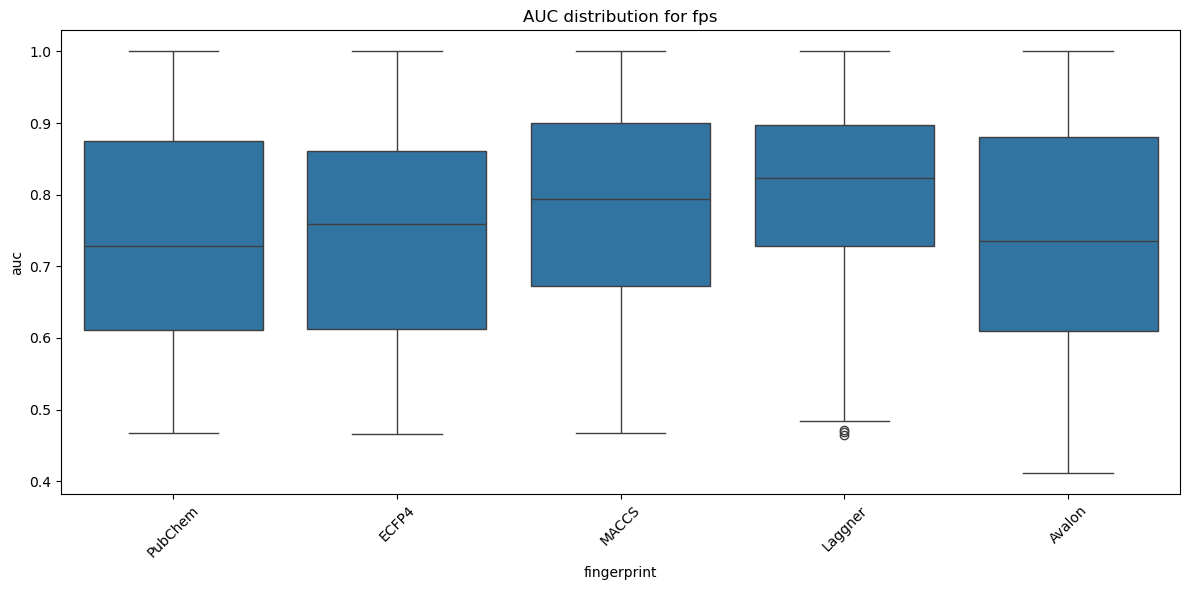

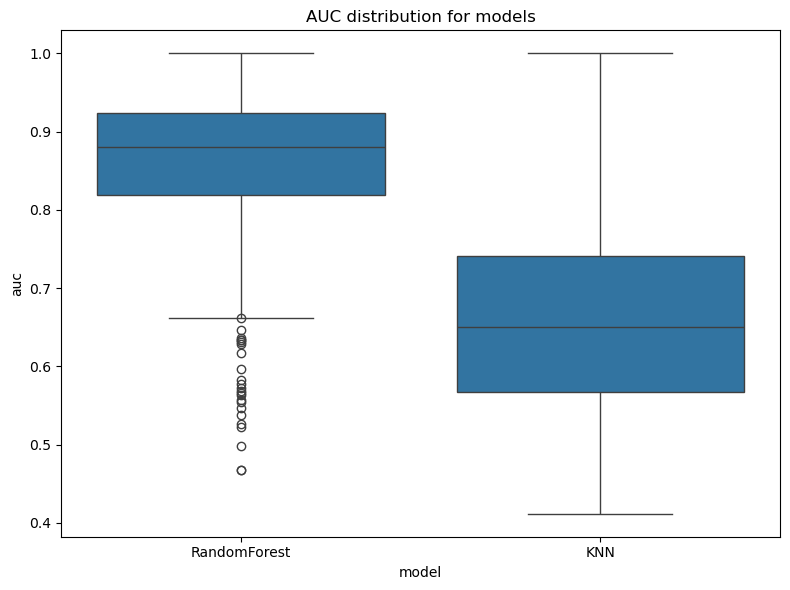

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=results_clean, x='fingerprint', y='auc')
plt.title('AUC distribution for fps')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('auc_by_fingerprint.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=results_clean, x='model', y='auc')
plt.title('AUC distribution for models')
plt.tight_layout()
plt.savefig('auc_by_model.png', dpi=300, bbox_inches='tight')
plt.show()


In [17]:
target_ranks = {t: i for i, t in enumerate(chosen_targets, 1)}  

results_plot = results_clean.copy()
results_plot['rank'] = results_plot['target_id'].map(target_ranks)


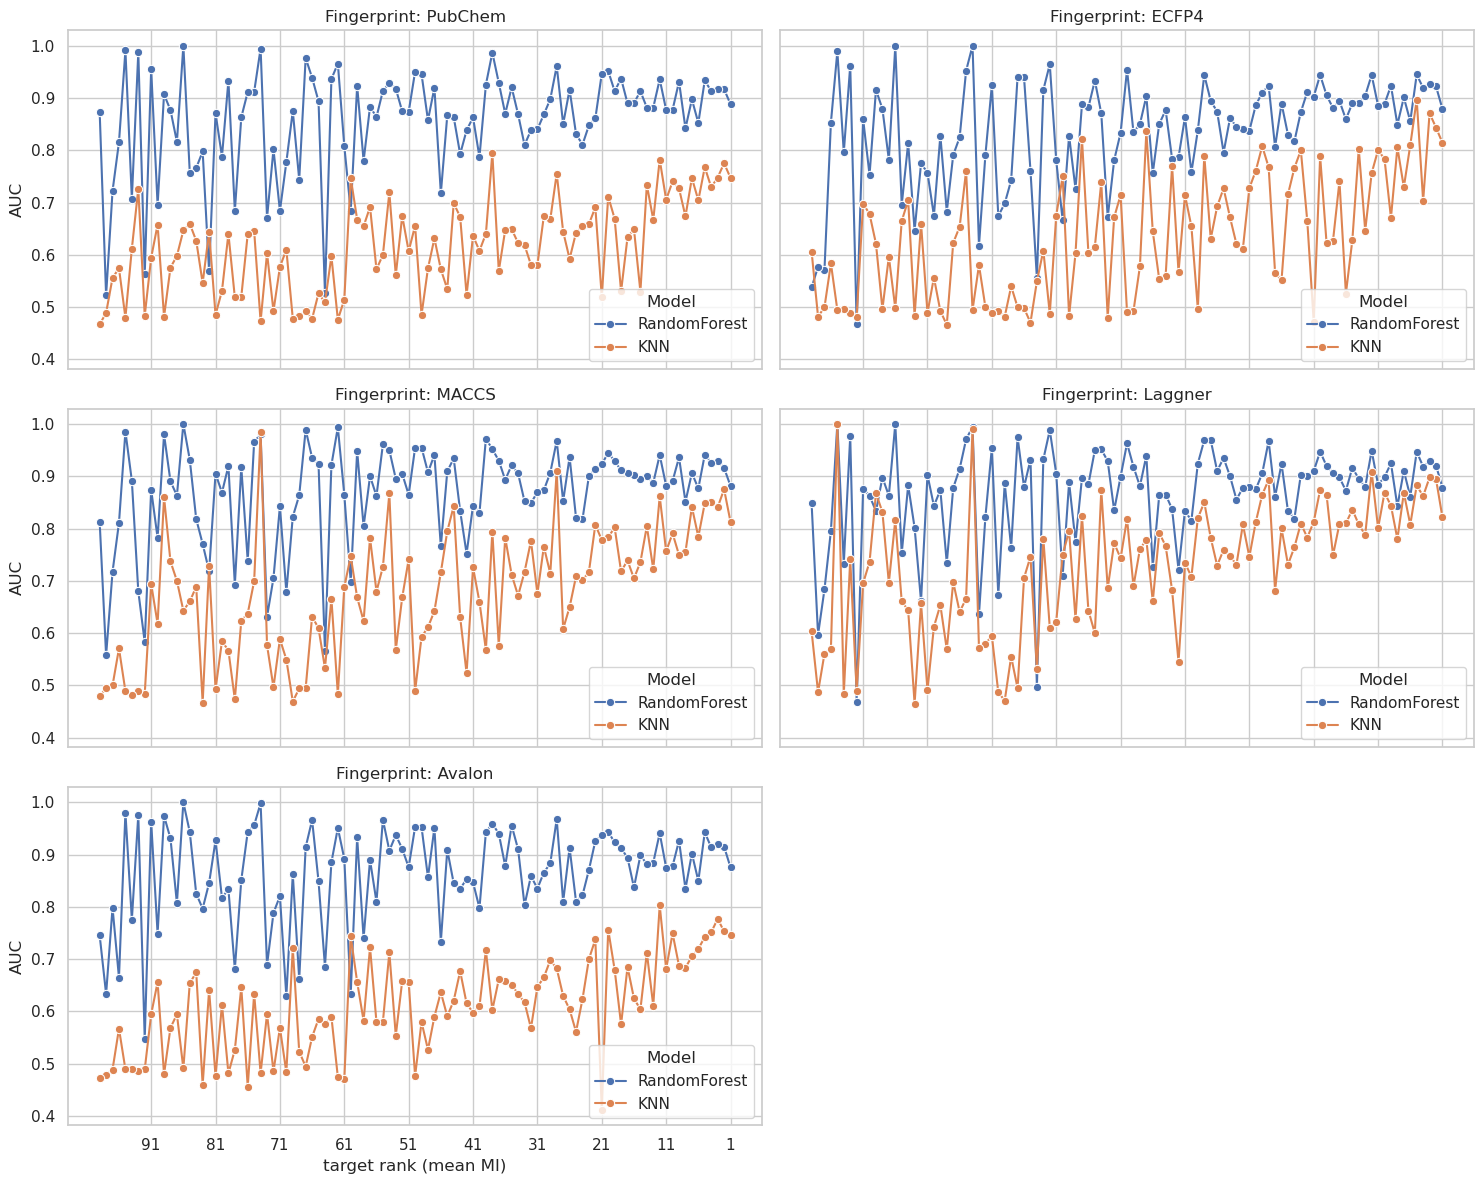

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

fingerprints = results_plot['fingerprint'].unique()
n_fp = len(fingerprints)
ncols = 2
nrows = (n_fp + 1) // ncols

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4*nrows), sharex=True, sharey=True)
axs = axs.flatten()

for i, fp in enumerate(fingerprints):
    ax = axs[i]
    fp_df = results_plot[results_plot['fingerprint'] == fp]
    fp_df = fp_df.dropna(subset=['auc', 'rank'])
    sns.lineplot(
        data=fp_df, x='rank', y='auc', hue='model', marker='o', ax=ax
    )
    ax.invert_xaxis()
    ax.set_title(f'Fingerprint: {fp}')
    ax.set_xlabel('target rank (mean MI)')
    ax.set_ylabel('AUC')
    ax.legend(title='Model')
    ax.set_xticks(list(range(1, 101, 10)))

for j in range(n_fp, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


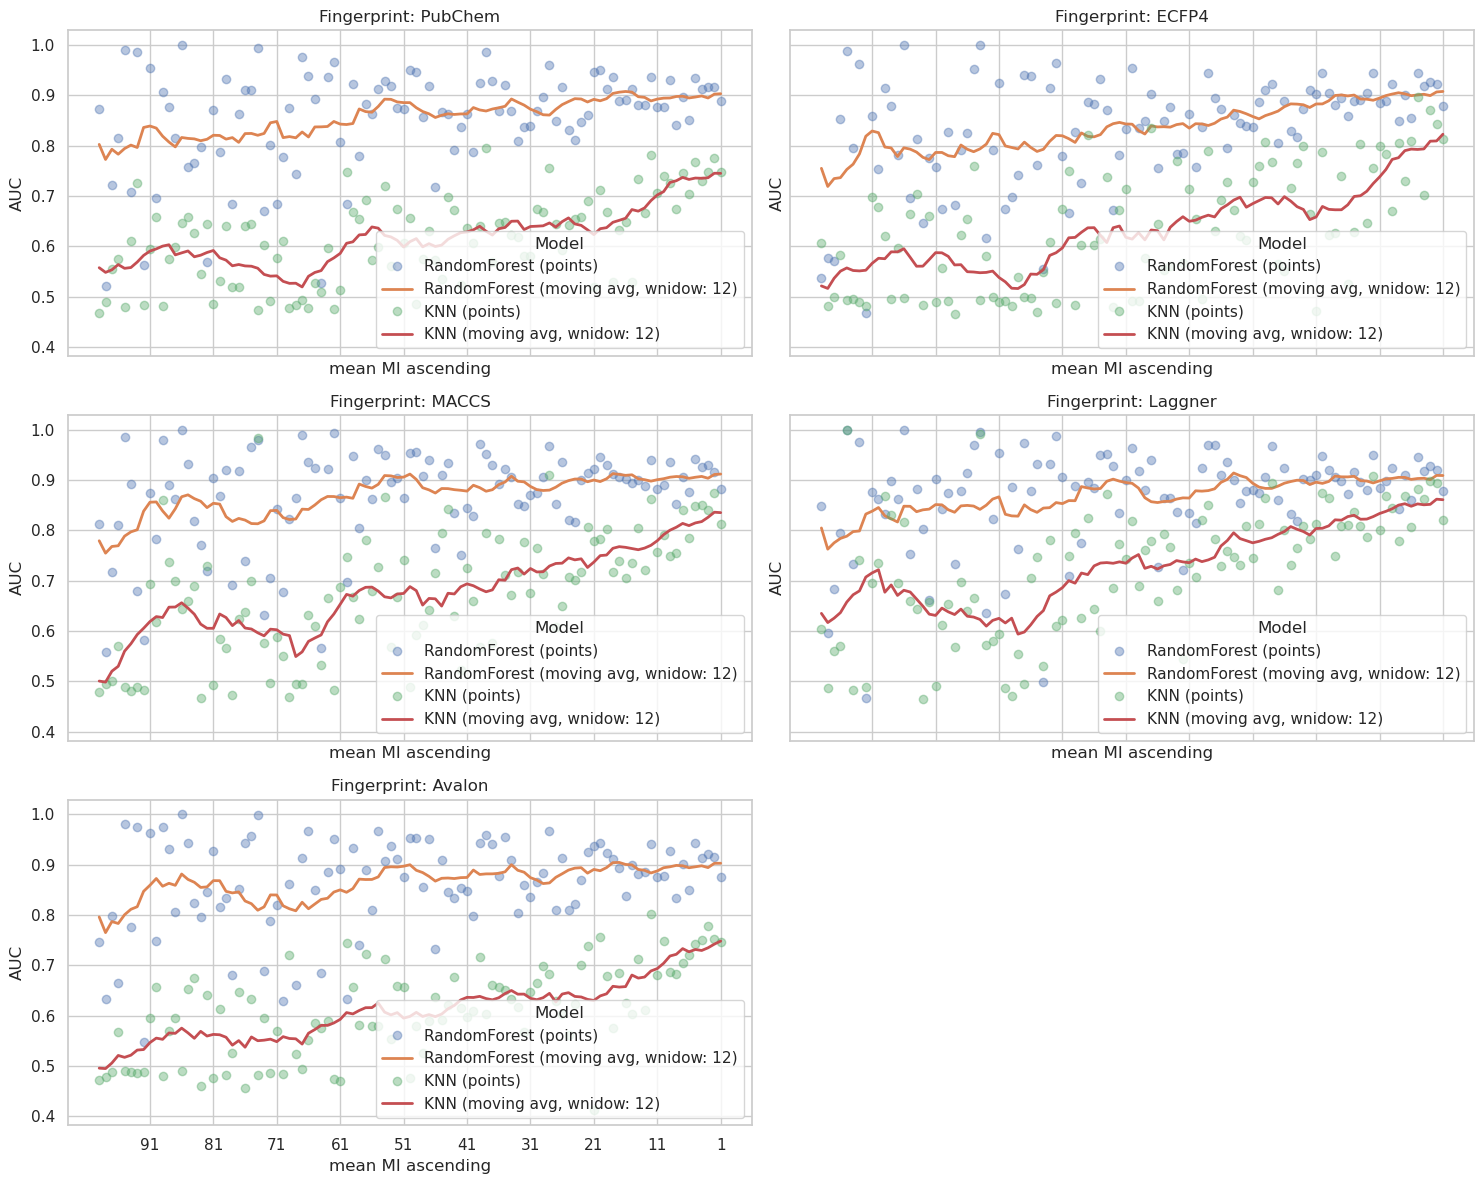

In [19]:


sns.set(style="whitegrid")

window = 12

fingerprints = results_plot['fingerprint'].unique()
n_fp = len(fingerprints)
ncols = 2
nrows = (n_fp + 1) // ncols

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 4*nrows), sharex=True, sharey=True)
axs = axs.flatten()

for i, fp in enumerate(fingerprints):
    ax = axs[i]
    fp_df = results_plot[results_plot['fingerprint'] == fp].dropna(subset=['auc', 'rank'])
    
    for model in ['RandomForest', 'KNN']:
        mdl = fp_df[fp_df['model'] == model]
        mdl_sorted = mdl.sort_values('rank')
    
        rolling_auc = mdl_sorted['auc'].rolling(window, center=True, min_periods=1).mean()
        ax.plot(mdl_sorted['rank'], mdl_sorted['auc'], 'o', label=f"{model} (points)", alpha=0.4)
        ax.plot(mdl_sorted['rank'], rolling_auc, '-', label=f"{model} (moving avg, wnidow: {window})", linewidth=2)
    ax.set_title(f'Fingerprint: {fp}')
    ax.set_xlabel('mean MI ascending')
    ax.set_ylabel('AUC')
    ax.legend(title='Model')
    ax.invert_xaxis()
    ax.set_xticks(list(range(1, 101, 10)))

for j in range(n_fp, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


In [20]:
target_first = chosen_targets[0]
target_middle = chosen_targets[len(chosen_targets)//2]
target_last = chosen_targets[-1]

selected_targets = [
    ("first (highest MI)", target_first),
    ("middle of rankin MI", target_middle),
    ("last (lowest MI)", target_last),
]


display_table = []

for label, t_id in selected_targets:
    sub = results_clean[results_clean['target_id'] == t_id][['fingerprint', 'model', 'auc', 'aupr', 'precision', 'recall']]
    sub['target'] = label
    display_table.append(sub)

import pandas as pd
display_df = pd.concat(display_table, ignore_index=True)

display_df = display_df[['target', 'fingerprint', 'model', 'auc', 'aupr', 'precision', 'recall']]

print("comparision of selected targets:\n")
print(display_df.round(4).to_string(index=False))


comparision of selected targets:

             target fingerprint        model    auc   aupr  precision  recall
 first (highest MI)     PubChem RandomForest 0.8881 0.7795     0.7667  0.6133
 first (highest MI)     PubChem          KNN 0.7472 0.5003     0.6842  0.3467
 first (highest MI)       ECFP4 RandomForest 0.8789 0.7756     0.7419  0.6133
 first (highest MI)       ECFP4          KNN 0.8143 0.6052     0.6415  0.4533
 first (highest MI)       MACCS RandomForest 0.8815 0.7726     0.7015  0.6267
 first (highest MI)       MACCS          KNN 0.8129 0.5883     0.6140  0.4667
 first (highest MI)     Laggner RandomForest 0.8784 0.7578     0.6857  0.6400
 first (highest MI)     Laggner          KNN 0.8213 0.6061     0.6462  0.5600
 first (highest MI)      Avalon RandomForest 0.8754 0.7275     0.7000  0.6533
 first (highest MI)      Avalon          KNN 0.7465 0.5153     0.6286  0.2933
middle of rankin MI     PubChem RandomForest 0.8733 0.2600     0.0000  0.0000
middle of rankin MI     PubChe

In [21]:
display_df.to_latex()

'\\begin{tabular}{llllrrrr}\n\\toprule\n & target & fingerprint & model & auc & aupr & precision & recall \\\\\n\\midrule\n0 & first (highest MI) & PubChem & RandomForest & 0.888079 & 0.779518 & 0.766667 & 0.613333 \\\\\n1 & first (highest MI) & PubChem & KNN & 0.747192 & 0.500273 & 0.684211 & 0.346667 \\\\\n2 & first (highest MI) & ECFP4 & RandomForest & 0.878883 & 0.775620 & 0.741935 & 0.613333 \\\\\n3 & first (highest MI) & ECFP4 & KNN & 0.814286 & 0.605156 & 0.641509 & 0.453333 \\\\\n4 & first (highest MI) & MACCS & RandomForest & 0.881478 & 0.772602 & 0.701493 & 0.626667 \\\\\n5 & first (highest MI) & MACCS & KNN & 0.812939 & 0.588294 & 0.614035 & 0.466667 \\\\\n6 & first (highest MI) & Laggner & RandomForest & 0.878424 & 0.757761 & 0.685714 & 0.640000 \\\\\n7 & first (highest MI) & Laggner & KNN & 0.821346 & 0.606107 & 0.646154 & 0.560000 \\\\\n8 & first (highest MI) & Avalon & RandomForest & 0.875402 & 0.727488 & 0.700000 & 0.653333 \\\\\n9 & first (highest MI) & Avalon & KNN & 

In [22]:
rank_idx = 98

if not (0 <= rank_idx < len(chosen_targets)):
    raise ValueError(f"rank_idx out of range 0-{len(chosen_targets)-1}")

target_id = chosen_targets[rank_idx]

print(f'\nchoosen target: {target_id} (position in mean MI score ranking: {rank_idx+1}/{len(chosen_targets)})')


bench = results_clean[results_clean['target_id'] == target_id][['fingerprint', 'model', 'auc', 'aupr', 'precision', 'recall']]

if bench.empty:
    print("no benchmark for choosen target")
else:

    bench = bench.sort_values(['fingerprint', 'model'])
    print("\nBENCHMARK (model × fingerprint) for choosen targe:\n")
    print(bench.round(4).to_string(index=False))



choosen target: 10050551 (position in mean MI score ranking: 99/100)

BENCHMARK (model × fingerprint) for choosen targe:

fingerprint        model    auc   aupr  precision  recall
     Avalon          KNN 0.4726 0.0144        0.0     0.0
     Avalon RandomForest 0.7454 0.0692        0.0     0.0
      ECFP4          KNN 0.6063 0.0335        0.0     0.0
      ECFP4 RandomForest 0.5379 0.0242        0.0     0.0
    Laggner          KNN 0.6036 0.0316        0.0     0.0
    Laggner RandomForest 0.8481 0.1221        0.0     0.0
      MACCS          KNN 0.4799 0.0144        0.0     0.0
      MACCS RandomForest 0.8130 0.0946        0.0     0.0
    PubChem          KNN 0.4672 0.0144        0.0     0.0
    PubChem RandomForest 0.8736 0.0804        0.0     0.0
